In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
DPI = 350

In [2]:
FIGURES = Path("../") / 'results/figures'
FIGURES.mkdir(exist_ok=True)
TABLES = Path("../") / 'results/tables'
TABLES.mkdir(exist_ok=True)

In [3]:
named_colors = {
    "black": "#000000",
    "orange": "#e69f00",
    "skyblue": "#56b4e9",
    "bluish green": "#009e73",
    "yellow": "#f0e442",
    "blue": "#0072b2",
    "vermilion": "#d55e00",
    "reddish purple": "#cc79a7",
}
cud_palette = list(named_colors.values())

In [4]:
sns.set_style("whitegrid")
sns.set_palette(cud_palette)

## Parameter space exploration

In [5]:
ava_df = pd.read_csv("../results/lrge_ava_estimates.csv")
ava_df

sample strategy  n_reads  repeat   estimate   memory  cpu_time
0      ATCC_35897     long    50000       0  2822438.0  2782088    914.89
1      ATCC_19119     long    50000       0  2976251.0  1531048    312.56
2         BPH2947     long    50000       0  2985959.0  5464932   1896.34
3      ATCC_10708     long    50000       0  4766843.0   758728     59.15
4            KPC2     long    50000       0  5939814.0  6311512   1525.81
..            ...      ...      ...     ...        ...      ...       ...
331  ATCC_BAA-679     rand     5000       2  3017667.0   300256     13.83
332  ATCC_BAA-679     rand     5000       0  2952920.0   314212     14.50
333    ATCC_25922     rand     5000       0  5228012.0   285324     17.24
334    ATCC_25922     rand     5000       2  5218293.0   268132     16.16
335    ATCC_25922     rand     5000       1  5218149.0   288948     13.69

[336 rows x 7 columns]

In [6]:
twoset_df = pd.read_csv("../results/lrge_2set_estimates.csv")
# rename the 'longest' column to 'query' and the 'overlap' column to 'target'
twoset_df = twoset_df.rename(columns={"longest": "query", "overlap": "target"})
twoset_df

sample strategy  query  target  repeat      estimate   memory  \
0       ATCC_35897     long   5000    1000       0  2.700825e+06  1027036   
1       ATCC_19119     long   5000    1000       0  2.898175e+06  1107080   
2          BPH2947     long   5000    1000       0  2.526618e+06  1604472   
3       ATCC_10708     long   5000    1000       0  4.392490e+06   908236   
4             KPC2     long   5000    1000       0  4.662014e+06  2095688   
...            ...      ...    ...     ...     ...           ...      ...   
2011  ATCC_BAA-679     rand    100   10000       2  3.029200e+06    71424   
2012  ATCC_BAA-679     rand    100   10000       0  3.016585e+06    63424   
2013    ATCC_25922     rand    100   10000       0  5.067147e+06    61056   
2014    ATCC_25922     rand    100   10000       1  5.390512e+06    62784   
2015    ATCC_25922     rand    100   10000       2  5.254090e+06    62208   

      cpu_time  
0        50.65  
1        46.82  
2        93.09  
3        28.05  
4        90.21  
...        ...  
2011      4.78  
2012      4.39  
2013      6.32  
2014      6.26  
2015      5.90  

[2016 rows x 8 columns]

In [7]:
samples = set(ava_df["sample"])

In [8]:
true_sizes = {}
for sample in samples:
    size = int(Path(f"../data/true_sizes/{sample}.gsize").read_text())
    true_sizes[sample] = size

In [9]:
ava_df["true_size"] = ava_df["sample"].map(true_sizes)
ava_df["rel_size"] = ava_df["estimate"] / ava_df["true_size"]
ava_df["rel_err"] = (ava_df["estimate"] - ava_df["true_size"]) / ava_df["true_size"] * 100
ava_df["method"] = "ava"
twoset_df["true_size"] = twoset_df["sample"].map(true_sizes)
twoset_df["rel_size"] = twoset_df["estimate"] / twoset_df["true_size"]
twoset_df["rel_err"] = (twoset_df["estimate"] - twoset_df["true_size"]) / twoset_df["true_size"] * 100
twoset_df["method"] = "2set"

In [10]:
def add_identity(axes, *line_args, **line_kwargs):
    (identity,) = axes.plot([], [], *line_args, **line_kwargs)

    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])

    callback(axes)
    axes.callbacks.connect("xlim_changed", callback)
    axes.callbacks.connect("ylim_changed", callback)
    return axes

<>:90: SyntaxWarning: invalid escape sequence '\e'
<>:90: SyntaxWarning: invalid escape sequence '\e'
/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_34338/161240914.py:90: SyntaxWarning: invalid escape sequence '\e'
  lab = f"{strategy} | $R^2$={r2:.3f} | $\epsilon_{{rel}}={mean_rel_err:.2f}$"


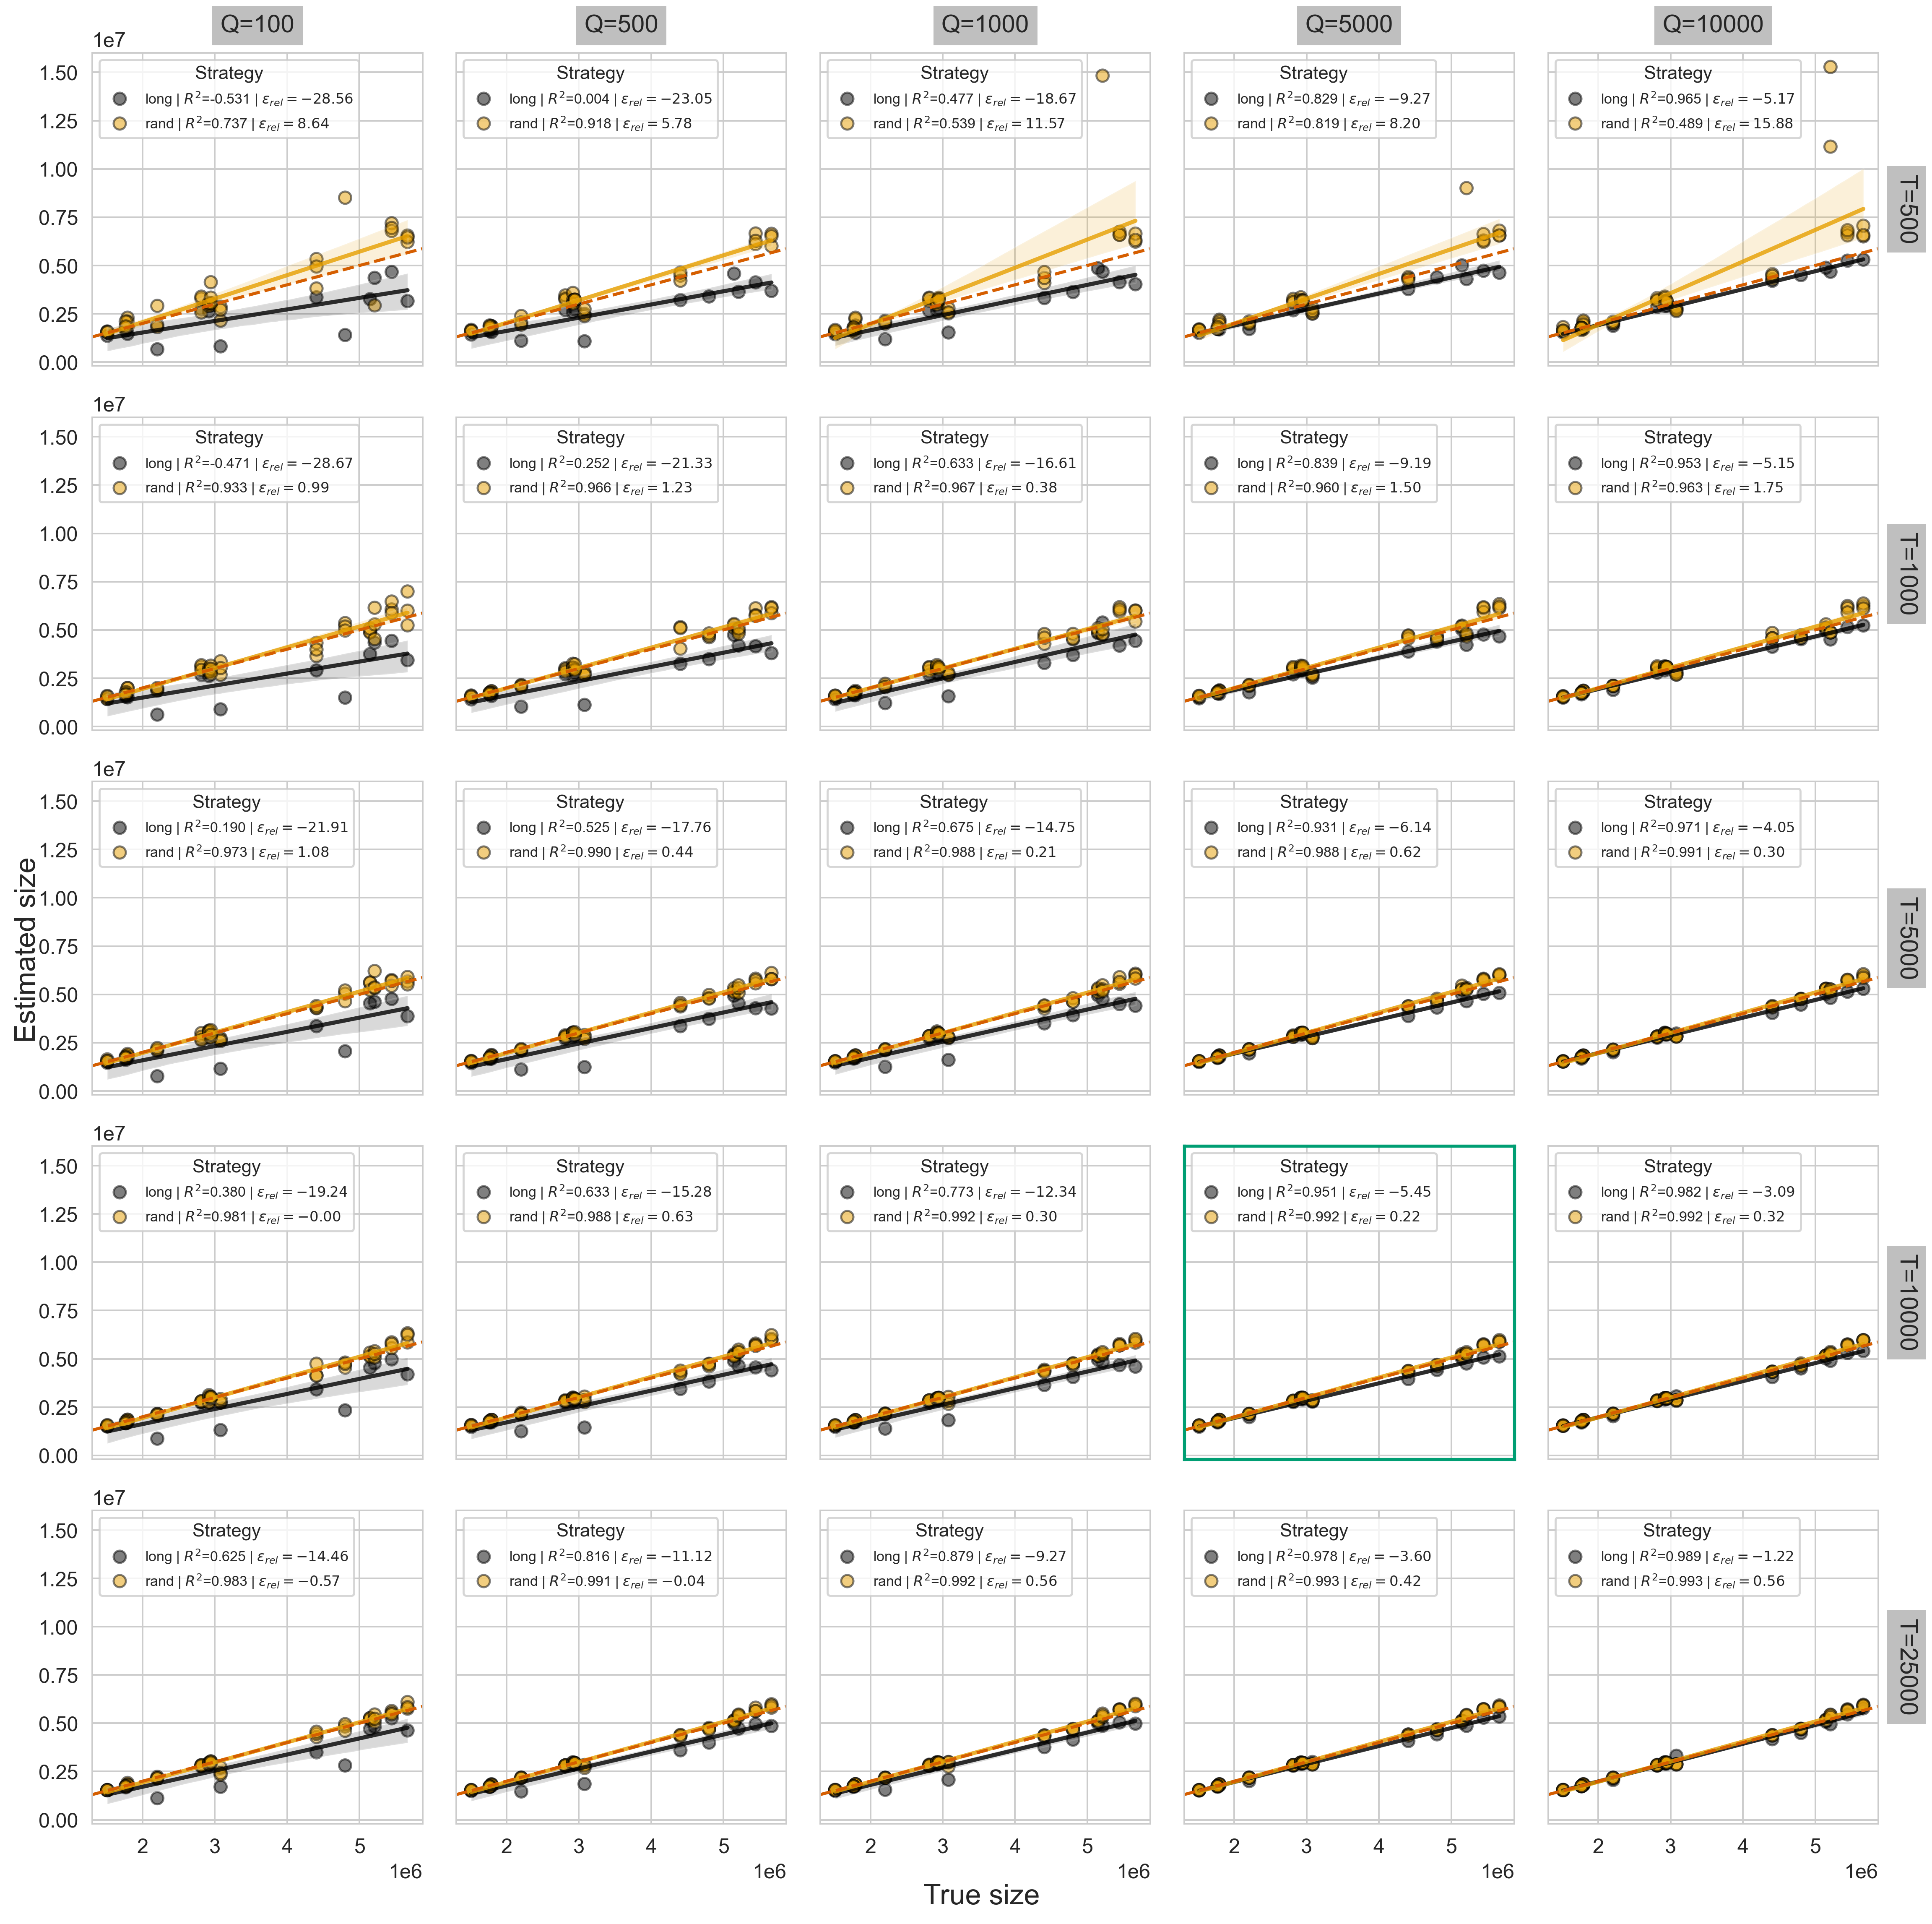

In [15]:
target_exclude = {100}
query_exclude = {25000}
data = twoset_df.query("target not in @target_exclude and query not in @query_exclude")
ls = sorted(data["query"].unique())
os = sorted(data["target"].unique())

fig, axes = plt.subplots(
    ncols=len(ls), nrows=len(os), figsize=(13, 13), dpi=DPI, sharex=True, sharey=True
)

# Add overall column titles
for i, L in enumerate(ls):
    axes[0, i].text(
        0.5,
        1.05,
        f"Q={L}",
        ha="center",
        va="bottom",
        bbox=dict(facecolor="grey", edgecolor="none", alpha=0.5),
        transform=axes[0, i].transAxes,
        fontsize=12,
    )

# Add row titles
for j, O in enumerate(os):
    axes[j, -1].text(
        1.05,
        0.5,
        f"T={O}",
        ha="left",
        va="center",
        bbox=dict(facecolor="grey", edgecolor="none", alpha=0.5),
        transform=axes[j, -1].transAxes,
        fontsize=12,
        rotation=270,
    )

for i, L in enumerate(ls):
    for j, O in enumerate(os):
        ax = axes[j, i]
        subdf = data.query("query == @L and target == @O and estimate < 1e9")
        sns.scatterplot(
            data=subdf,
            x="true_size",
            y="estimate",
            hue="strategy",
            ax=ax,
            alpha=0.5,
            lw=1,
            edgecolor="black",
        )
        sns.regplot(
            data=subdf.query("strategy == 'long'"),
            x="true_size",
            y="estimate",
            line_kws=dict(alpha=0.8, lw=2),
            ax=ax,
            color=cud_palette[0],
            scatter=False,
        )
        sns.regplot(
            data=subdf.query("strategy == 'rand'"),
            x="true_size",
            y="estimate",
            line_kws=dict(alpha=0.8, lw=2),
            ax=ax,
            color=cud_palette[1],
            scatter=False,
        )
        # ax.set_title(f"L={L}, O={O}")
        add_identity(ax, color=named_colors["vermilion"], ls="--")
        # ax.set_ylim(1, 1e7)
        # we add text to each plot with mean((est - true)/true)
        labels = []
        for strategy in subdf["strategy"].unique():
            diff_df = subdf.query("strategy == @strategy")
            diff = diff_df["estimate"] - diff_df["true_size"]
            rel_err = diff / diff_df["true_size"] * 100
            mean_rel_err = rel_err.mean()

            # calculate the coefficient of determination for the estimates with respect to the true size
            est_mean = diff_df["estimate"].mean()
            # total sum of squares
            ss_tot = ((diff_df["estimate"] - est_mean) ** 2).sum()
            # residual sum of squares (difference from the identity line where y = x)
            ss_res = ((diff_df["estimate"] - diff_df["true_size"]) ** 2).sum()
            # calculate R^2
            r2 = 1 - (ss_res / ss_tot)

            lab = f"{strategy} | $R^2$={r2:.3f} | $\epsilon_{{rel}}={mean_rel_err:.2f}$"

            labels.append(lab)

        handles, leglabels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title="Strategy", loc="upper left", fontsize=7, title_fontsize=9,)

        ax.set_xlabel("")
        ax.set_ylabel("")

# add a single y label to the middle left plot
fig.text(0.0, 0.5, "Estimated size", va="center", rotation="vertical", fontsize=14, ha="center")
fig.text(0.5, 0.0, "True size", ha="center", fontsize=14)

# change the colour of the axis border for the middle plot
ax = axes[3, 3]
for spine in ax.spines.keys():
    ax.spines[spine].set_color(named_colors["bluish green"])
    ax.spines[spine].set_linewidth(1.5)

fig.tight_layout()

In [13]:
fig.savefig(FIGURES / "lrge_2set_param_explore.pdf", bbox_inches="tight")

#

# Plotting all-v-all overlap results

In [16]:
def sample_extract(fpath: Path) -> str:
    return fpath.parts[-2]

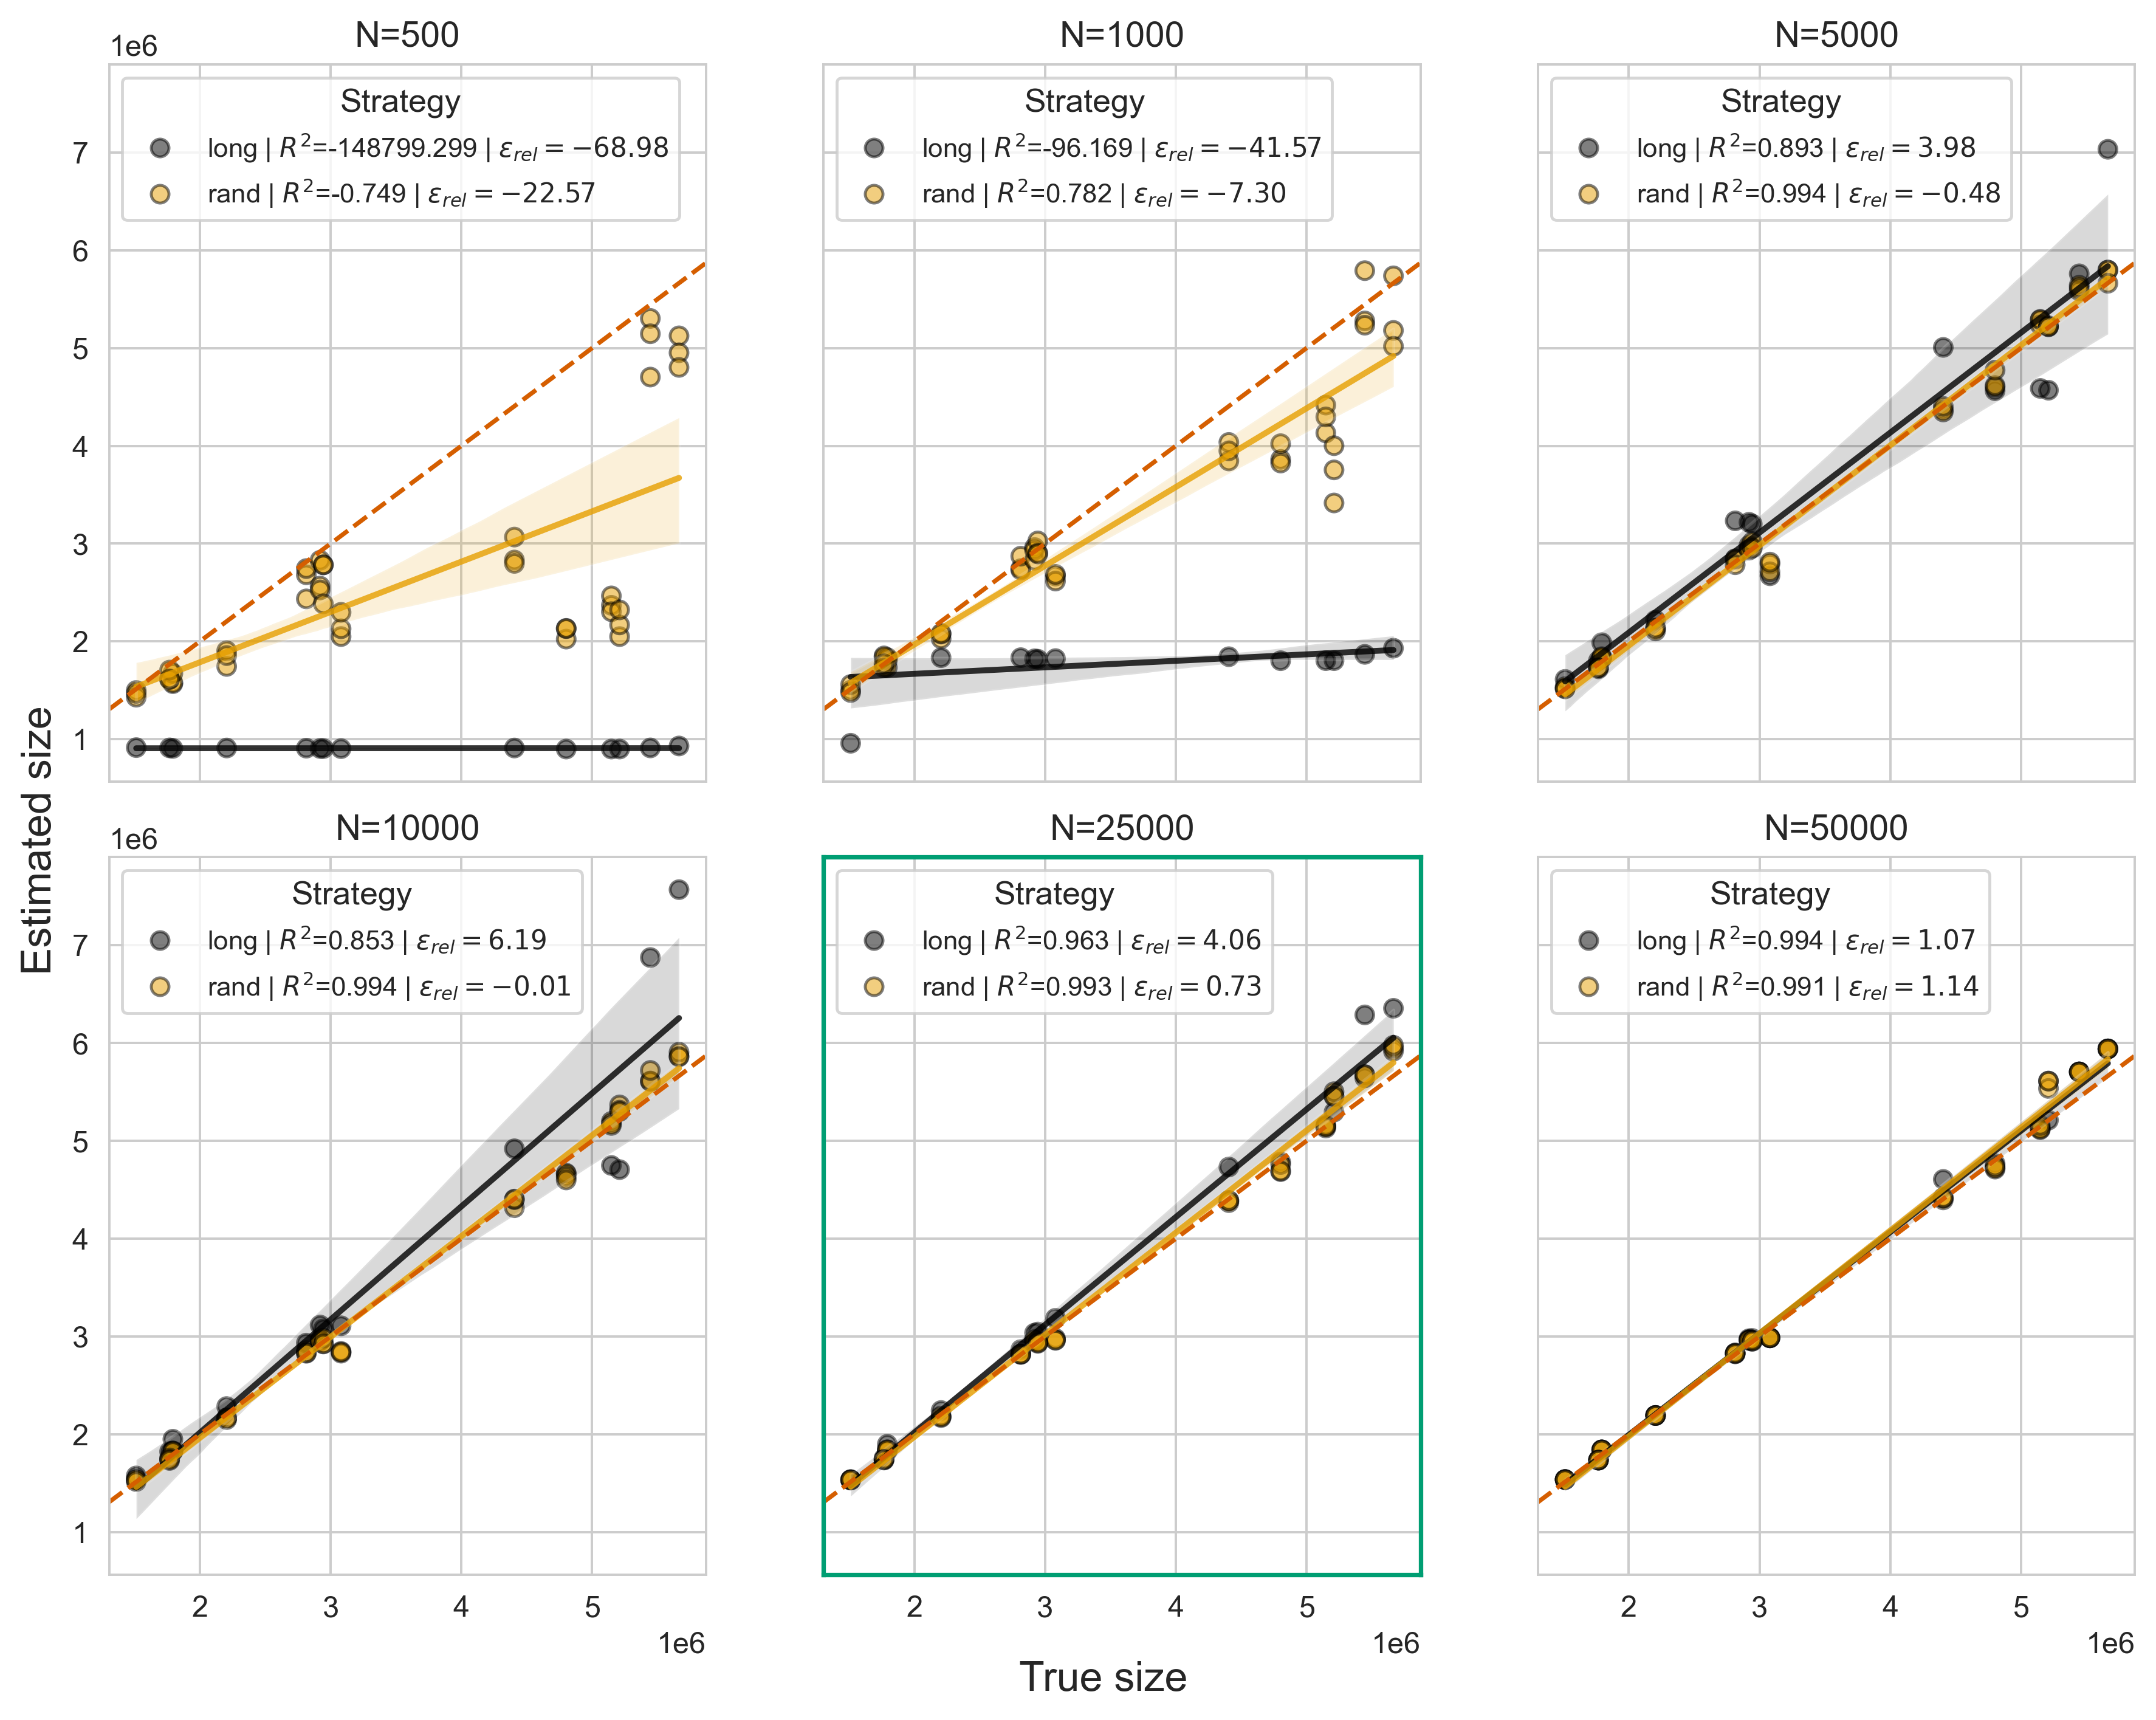

In [19]:
fig, axes = plt.subplots(dpi=DPI, figsize=(10, 8), nrows=2, ncols=3, sharex=True, sharey=True)
axes = axes.flatten()

data = ava_df
ns = sorted(data["n_reads"].unique())

for i, n in enumerate(ns):
    ax = axes[i]
    subdf = data.query("n_reads == @n and estimate < 1e9")
    sns.scatterplot(
        data=subdf,
        x="true_size",
        y="estimate",
        hue="strategy",
        ax=ax,
        alpha=0.5,
        lw=1,
        edgecolor="black",
    )
    sns.regplot(
        data=subdf.query("strategy == 'long'"),
        x="true_size",
        y="estimate",
        line_kws=dict(alpha=0.8, lw=2),
        ax=ax,
        color=cud_palette[0],
        scatter=False,
    )
    sns.regplot(
        data=subdf.query("strategy == 'rand'"),
        x="true_size",
        y="estimate",
        line_kws=dict(alpha=0.8, lw=2),
        ax=ax,
        color=cud_palette[1],
        scatter=False,
    )
    ax.set_title(f"N={n}")
    add_identity(ax, color=named_colors["vermilion"], ls="--")

    labels = []
    for strategy in subdf["strategy"].unique():
        diff_df = subdf.query("strategy == @strategy")
        diff = diff_df["estimate"] - diff_df["true_size"]
        rel_err = diff / diff_df["true_size"] * 100
        mean_rel_err = rel_err.mean()

        # calculate the coefficient of determination for the estimates with respect to the true size
        est_mean = diff_df["estimate"].mean()
        # total sum of squares
        ss_tot = ((diff_df["estimate"] - est_mean) ** 2).sum()
        # residual sum of squares (difference from the identity line where y = x)
        ss_res = ((diff_df["estimate"] - diff_df["true_size"]) ** 2).sum()
        # calculate R^2
        r2 = 1 - (ss_res / ss_tot)

        lab = rf"{strategy} | $R^2$={r2:.3f} | $\epsilon_{{rel}}={mean_rel_err:.2f}$"

        labels.append(lab)

    handles, leglabels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title="Strategy", loc="upper left", fontsize=9, title_fontsize=11,)

    ax.set_xlabel("")
    ax.set_ylabel("")

# add a single y label to the middle left plot
fig.text(0.0, 0.5, "Estimated size", va="center", rotation="vertical", fontsize=14, ha="center")
fig.text(0.5, 0.0, "True size", ha="center", fontsize=14)

# change the colour of the axis border for the chosen N plot
ax = axes[-2]
for spine in ax.spines.keys():
    ax.spines[spine].set_color(named_colors["bluish green"])
    ax.spines[spine].set_linewidth(1.5)

fig.tight_layout()

In [20]:
fig.savefig(FIGURES / "lrge_ava_param_explore.pdf", bbox_inches="tight")

# Looking at the Mash estimates

In [17]:
mash = pd.read_csv("../results/mash_estimates.csv")
mash

sample  sketch_size  min_copies  estimate  memory  cpu_time
0      ATCC_35897        10000          10   2813670  275268      7.95
1      ATCC_19119        10000          10   2906640  274372      7.43
2         BPH2947        10000          10   2995380  276672      8.52
3      ATCC_10708        10000          10   4711360  511536     12.54
4            KPC2        10000          10   5586690  511956     12.37
..            ...          ...         ...       ...     ...       ...
275        AMtb_1       100000           8   4431640  275228     14.48
276        MMC234       100000           8   2209750  140648      8.84
277    ATCC_33560       100000           8   1794050  140864      8.34
278  ATCC_BAA-679       100000           8   2956680  274448     11.35
279    ATCC_25922       100000           8   5268470  510784     22.03

[280 rows x 6 columns]

In [18]:
# get true sizes from the true_sizes dict
mash["true_size"] = [true_sizes[sample] for sample in mash["sample"]]
mash["rel_size"] = mash["estimate"] / mash["true_size"]
mash["rel_err"] = (mash["estimate"] - mash["true_size"]) / mash["true_size"] * 100
mash["method"] = "mash"


<>:54: SyntaxWarning: invalid escape sequence '\e'
<>:54: SyntaxWarning: invalid escape sequence '\e'
/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_56550/746914190.py:54: SyntaxWarning: invalid escape sequence '\e'
  lab = f"$R^2$={r2:.3f} | $\epsilon_{{rel}}={mean_rel_err:.2f}$"


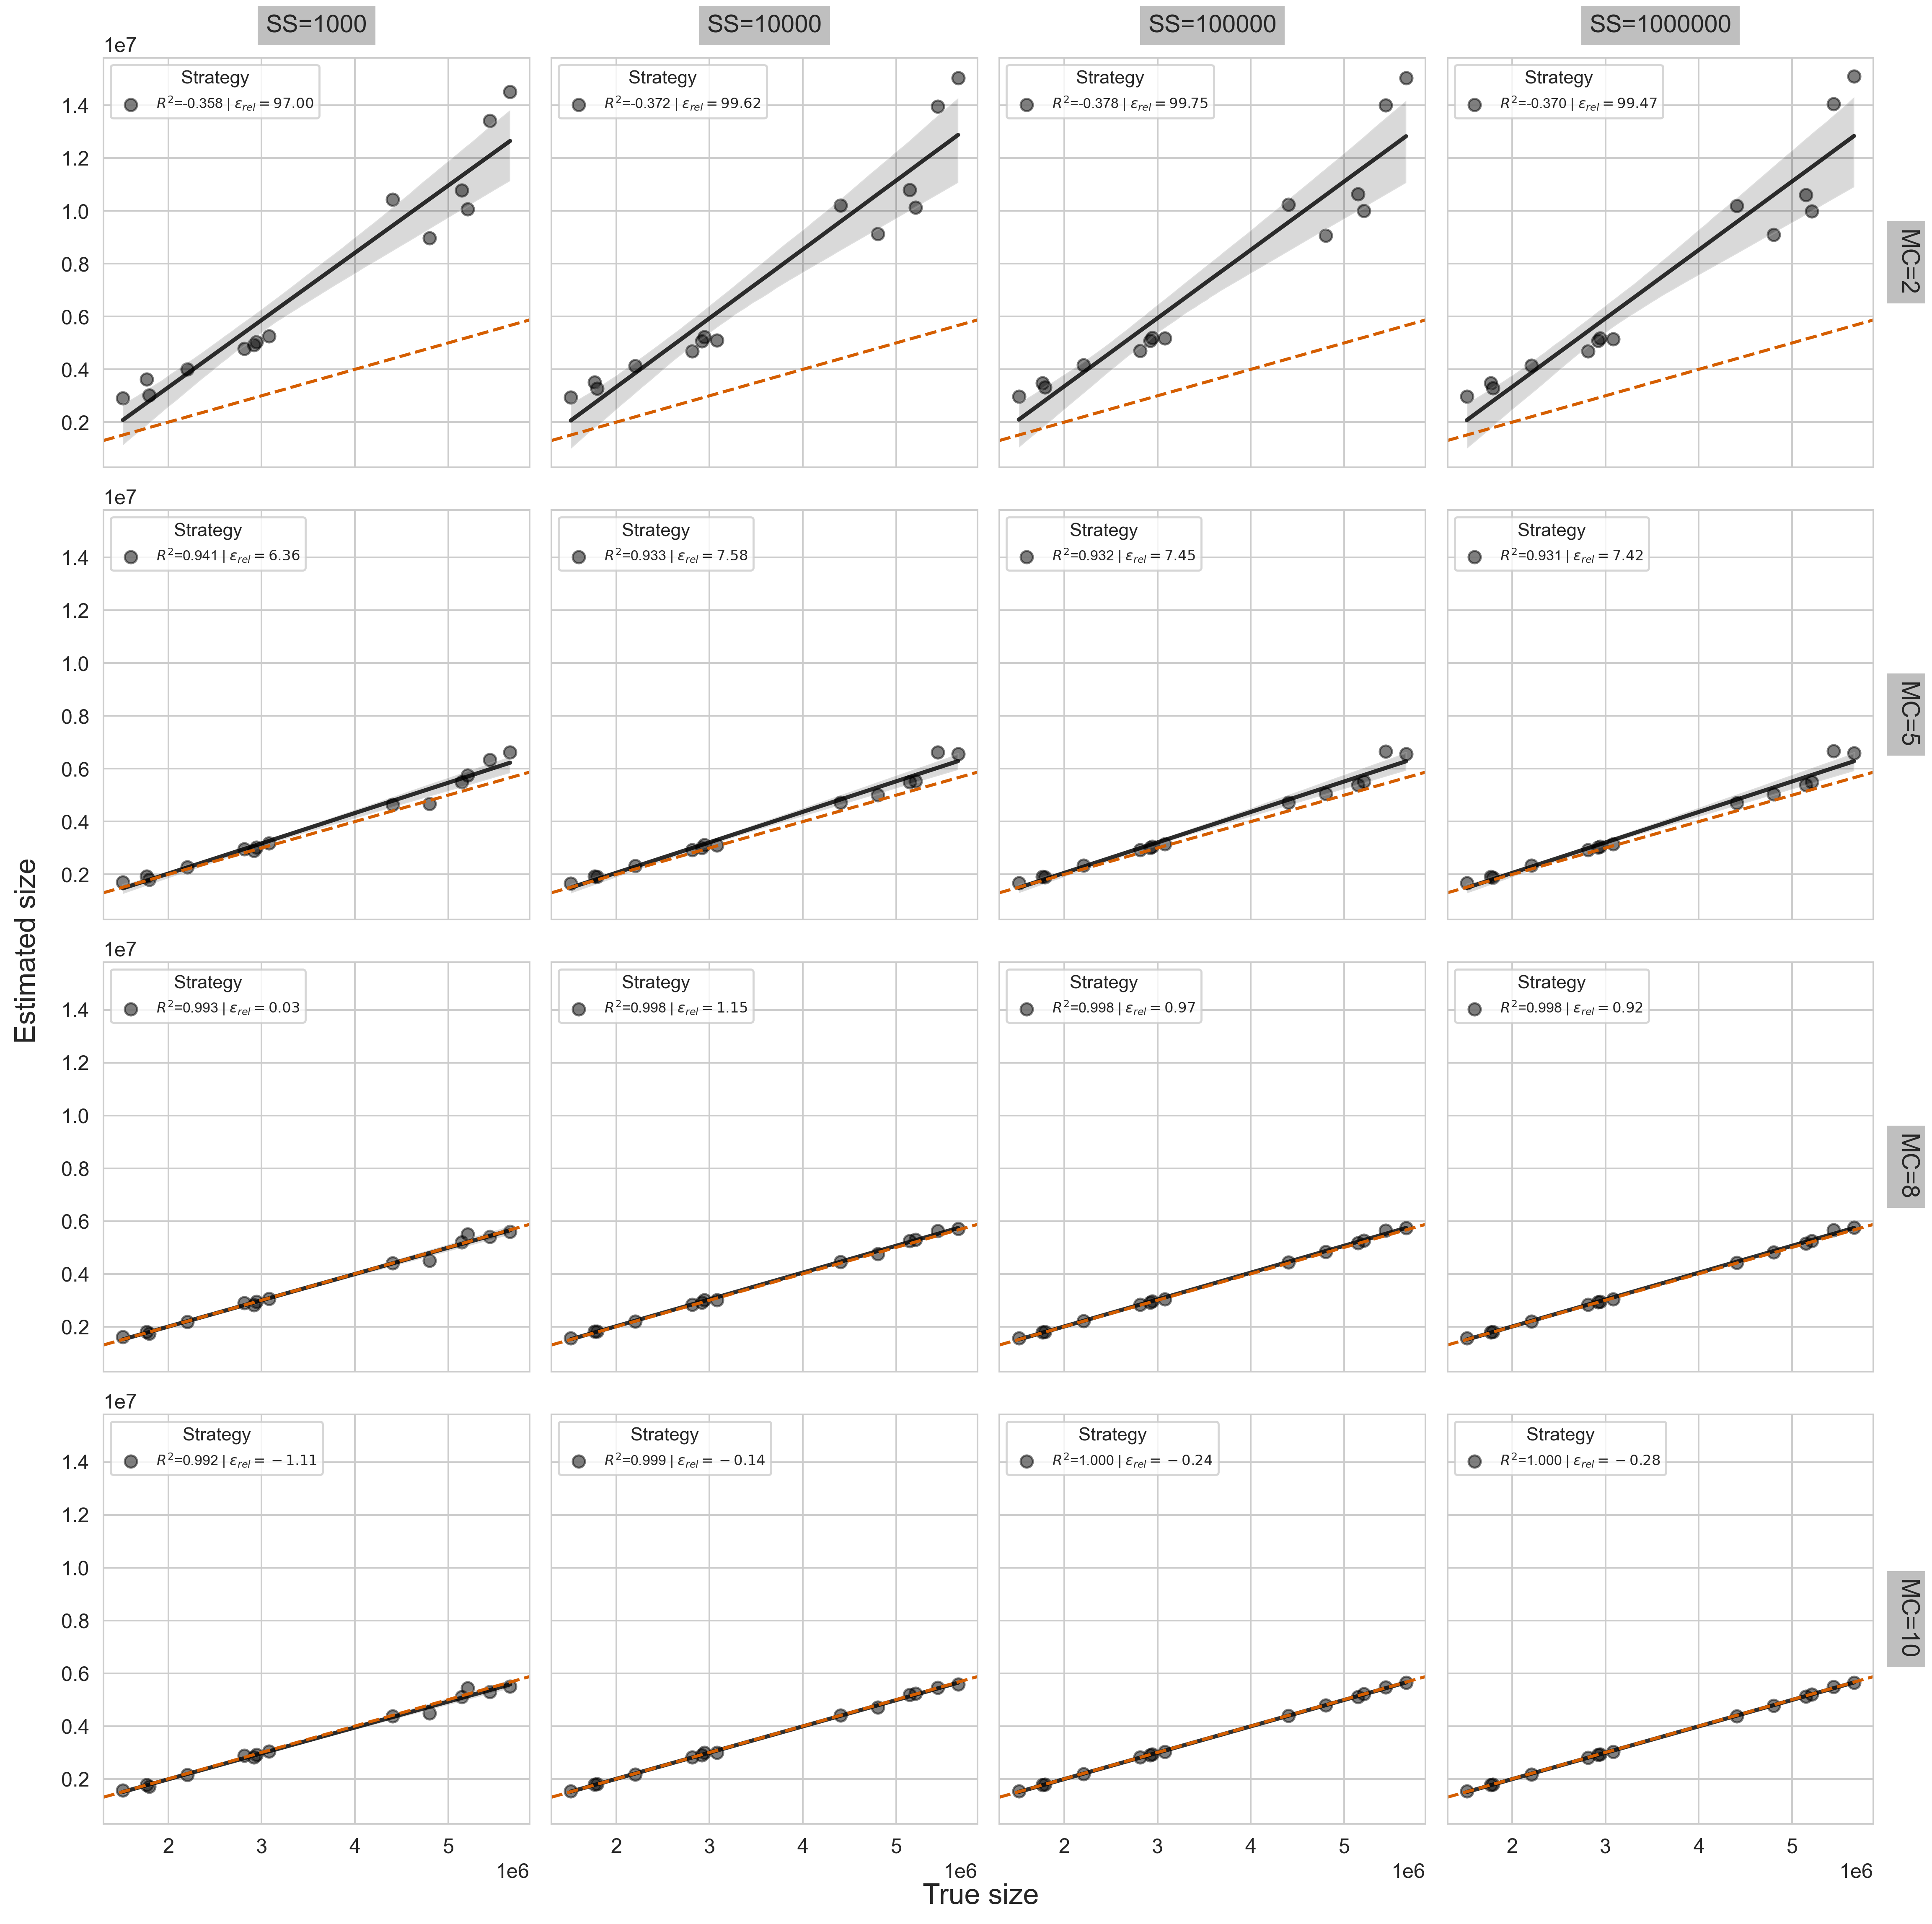

In [19]:
data = mash.query("min_copies > 1")
ss = sorted(data["sketch_size"].unique())
mc = sorted(data["min_copies"].unique())

fig, axes = plt.subplots(
    ncols=len(ss), nrows=len(mc), figsize=(13, 13), dpi=DPI, sharex=True, sharey=True
)

# Add overall column titles
for i, s in enumerate(ss):
    axes[0, i].text(
        0.5,
        1.05,
        f"SS={s}",
        ha="center",
        va="bottom",
        bbox=dict(facecolor="grey", edgecolor="none", alpha=0.5),
        transform=axes[0, i].transAxes,
        fontsize=12,
    )

# Add row titles
for j, m in enumerate(mc):
    axes[j, -1].text(
        1.05,
        0.5,
        f"MC={m}",
        ha="left",
        va="center",
        bbox=dict(facecolor="grey", edgecolor="none", alpha=0.5),
        transform=axes[j, -1].transAxes,
        fontsize=12,
        rotation=270,
    )

for i, s in enumerate(ss):
    for j, m in enumerate(mc):
        ax = axes[j, i]
        subdf = data.query("sketch_size == @s and min_copies == @m and estimate < 1e12")
        diff_df = subdf
        diff = diff_df["estimate"] - diff_df["true_size"]
        rel_err = diff / diff_df["true_size"] * 100
        mean_rel_err = rel_err.mean()

        # calculate the coefficient of determination for the estimates with respect to the true size
        est_mean = diff_df["estimate"].mean()
        # total sum of squares
        ss_tot = ((diff_df["estimate"] - est_mean) ** 2).sum()
        # residual sum of squares (difference from the identity line where y = x)
        ss_res = ((diff_df["estimate"] - diff_df["true_size"]) ** 2).sum()
        # calculate R^2
        r2 = 1 - (ss_res / ss_tot)

        lab = f"$R^2$={r2:.3f} | $\epsilon_{{rel}}={mean_rel_err:.2f}$"
        sns.scatterplot(
            data=subdf,
            x="true_size",
            y="estimate",
            ax=ax,
            alpha=0.5,
            lw=1,
            edgecolor="black",
            label=lab,
            legend=True
        )
        sns.regplot(
            data=subdf,
            x="true_size",
            y="estimate",
            line_kws=dict(alpha=0.8, lw=2),
            ax=ax,
            color=cud_palette[0],
            scatter=False,
        )
        # ax.set_title(f"L={L}, O={O}")
        add_identity(ax, color=named_colors["vermilion"], ls="--")
        # ax.set_ylim(1, 1e7)
        # we add text to each plot with mean((est - true)/true)
        labels = []


        labels.append(lab)

        handles, leglabels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title="Strategy", loc="upper left", fontsize=7, title_fontsize=9,)

        ax.set_xlabel("")
        ax.set_ylabel("")

# add a single y label to the middle left plot
fig.text(0.0, 0.5, "Estimated size", va="center", rotation="vertical", fontsize=14, ha="center")
fig.text(0.5, 0.0, "True size", ha="center", fontsize=14)

# change the colour of the axis border for the middle plot
# ax = axes[3, 3]
# for spine in ax.spines.keys():
#     ax.spines[spine].set_color(named_colors["bluish green"])
#     ax.spines[spine].set_linewidth(1.5)

fig.tight_layout()

/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_56550/397982391.py:8: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.boxplot(
/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_56550/397982391.py:20: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.stripplot(


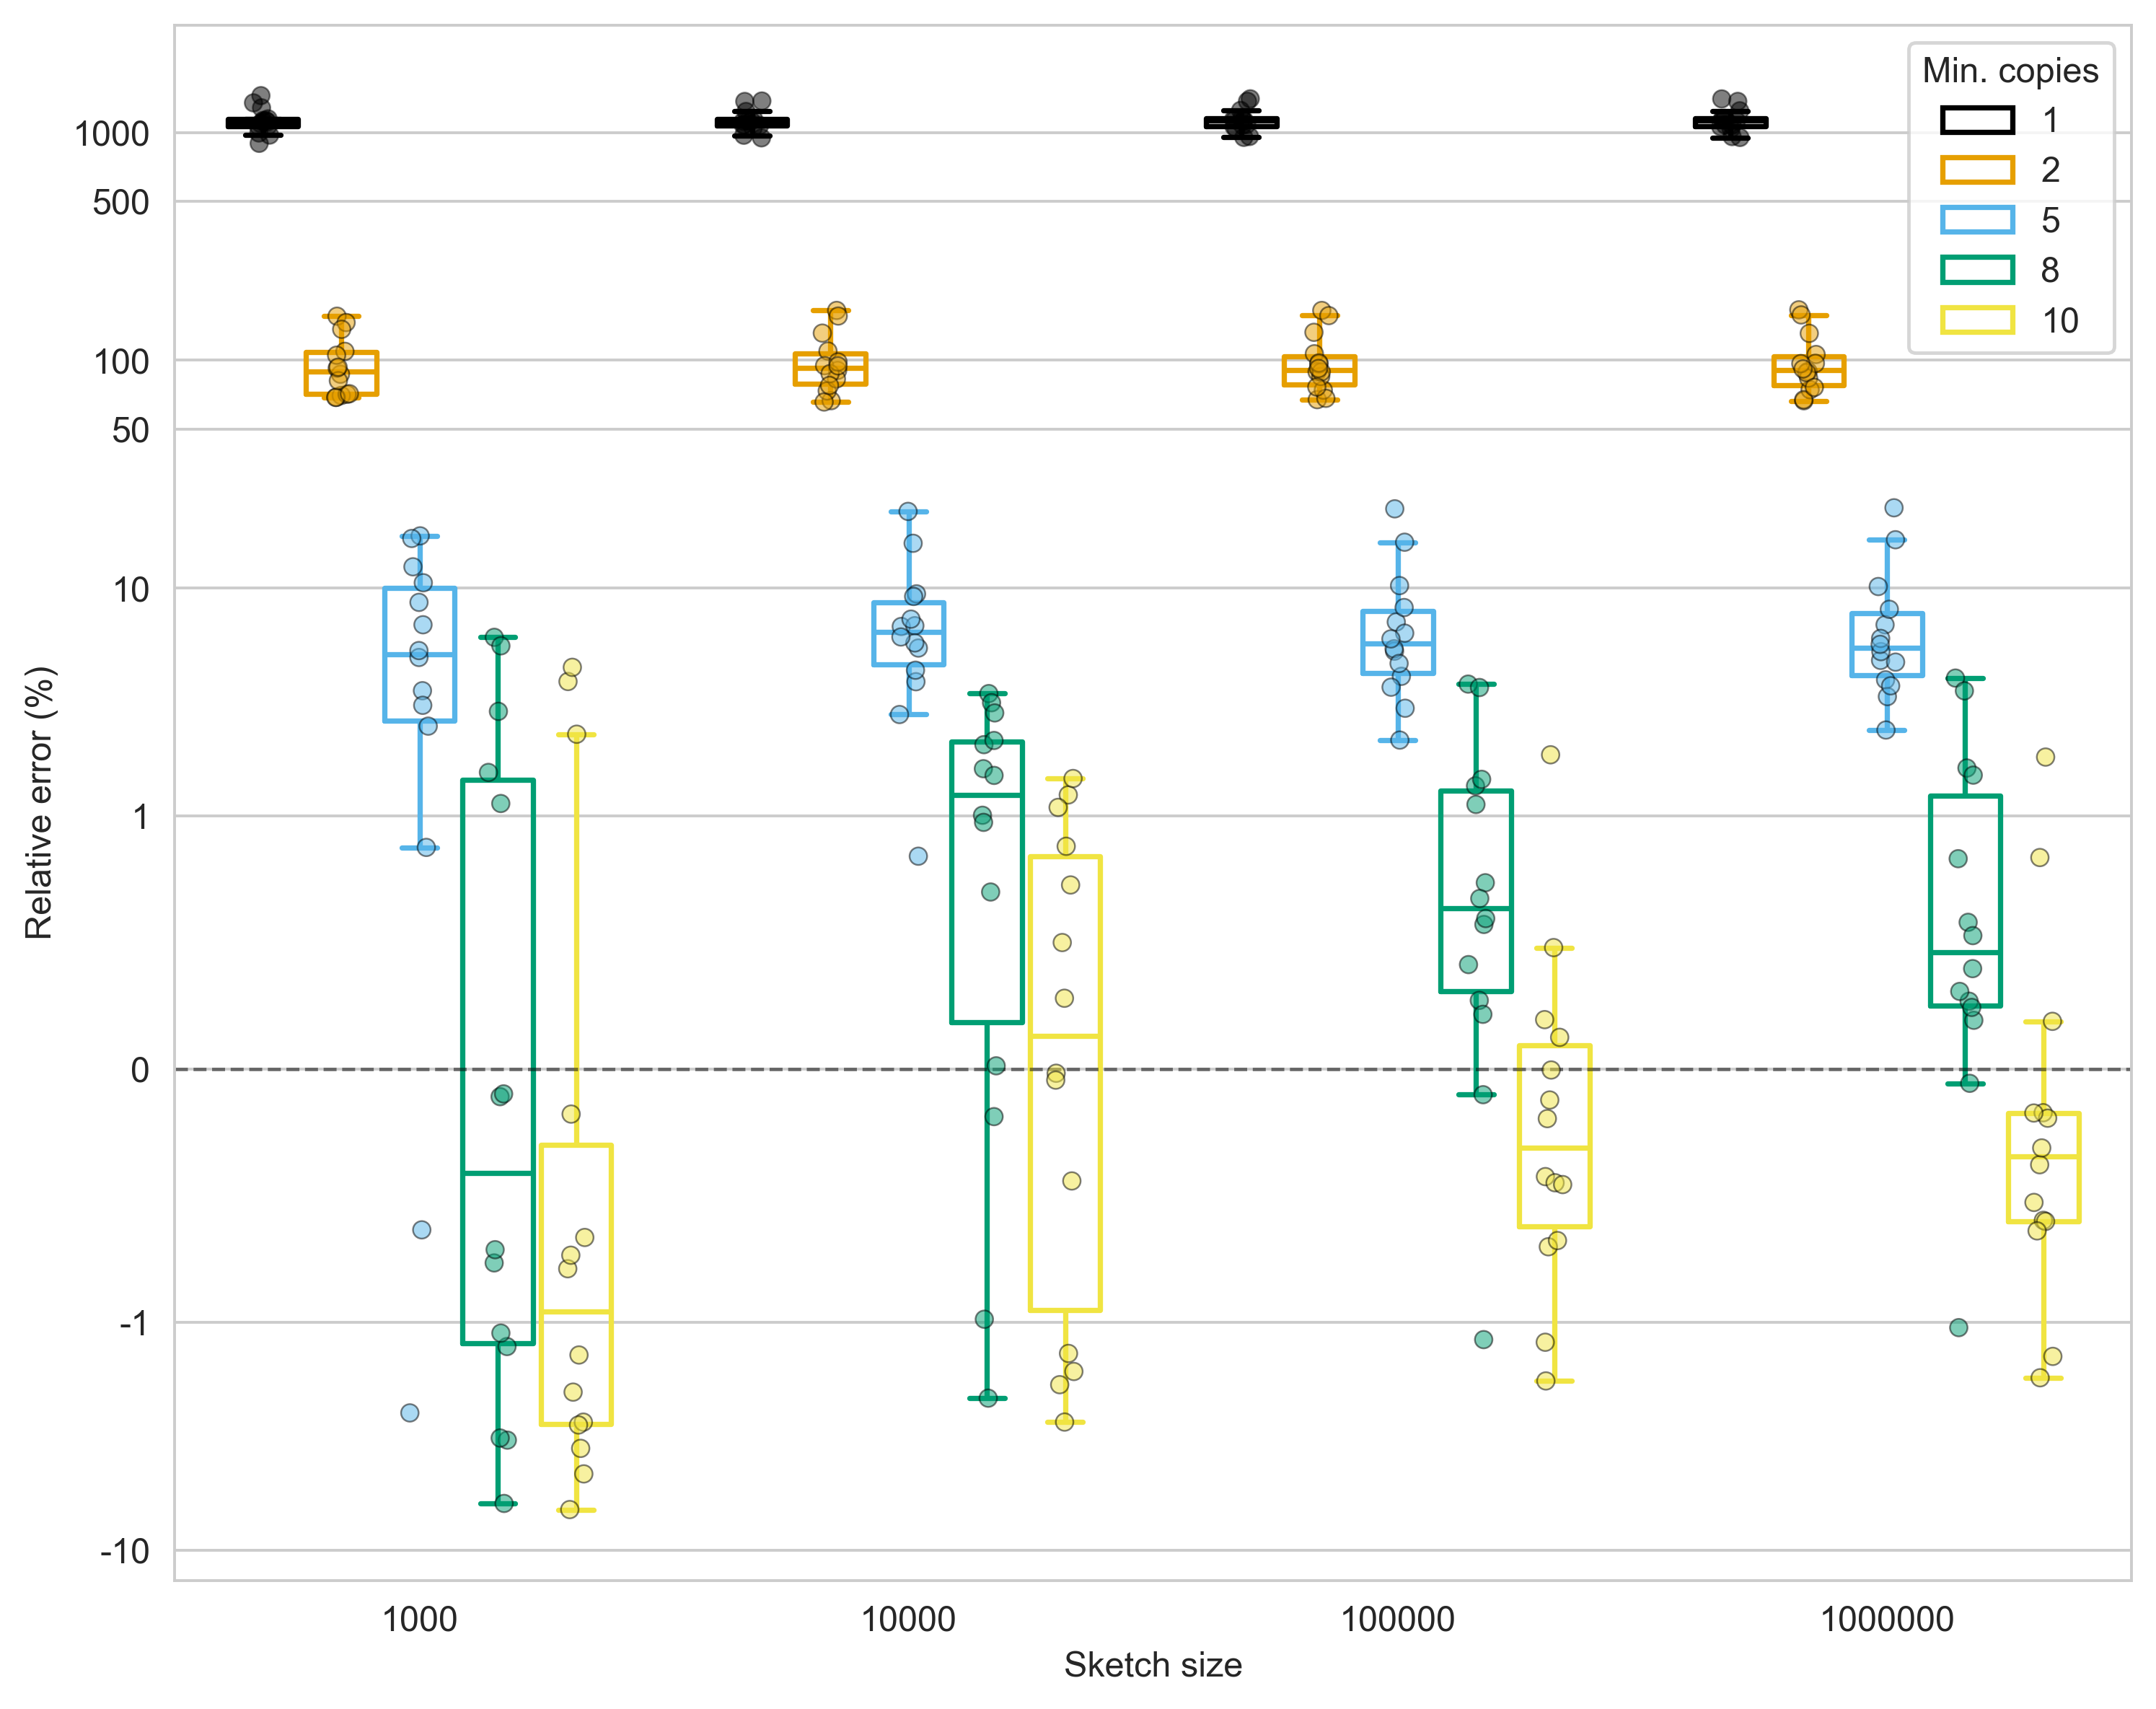

In [21]:
fig, ax = plt.subplots(dpi=DPI, figsize=(10, 8))

# use min copies that are a multiple of 2
data = mash#.query("min_copies > 1")

ax.set_yscale("symlog", linthresh=1)

sns.boxplot(
    data=data,
    x="sketch_size",
    y="rel_err",
    ax=ax,
    hue="min_copies",
    dodge=True,
    fill=False,
    fliersize=0,
    palette=cud_palette,
    gap=0.1
)
sns.stripplot(
    data=data,
    x="sketch_size",
    y="rel_err",
    ax=ax,
    hue="min_copies",
    dodge=True,
    alpha=0.5,
    palette=cud_palette,
    legend=False,
    edgecolor="black",
    linewidth=0.5,
)

ax.set_ylabel("Relative error (%)")
ax.set_xlabel("Sketch size")

# set the legend title to Min. copies
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="Min. copies")

yticks = [-10, -1, 0, 1, 10, 50, 100, 500, 1000]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks)

# make the y gridline at zero thicker
ax.axhline(0, color="black", lw=1, alpha=0.5, linestyle="--")

# ax.set_ylim(0.5, 2.0)

In [22]:
fig.savefig(FIGURES / "mash_param_explore.pdf", bbox_inches="tight")

In [23]:
gscope = pd.read_csv("../results/genomescope_estimates.csv")
gscope

sample  kmer_size  min_copies  estimate   memory  cpu_time
0      ATCC_35897         19          10   2806903  2400504     13.26
1      ATCC_19119         19          10   2904738  2491244     13.41
2         BPH2947         19          10   3390400  2654168     14.46
3      ATCC_10708         19          10   4847902  4143564     21.04
4            KPC2         19          10   5853734  3682584     20.40
..            ...        ...         ...       ...      ...       ...
331        AMtb_1         31           5   4318773  6889324     27.17
332        MMC234         31           5   2059293  3491824     15.48
333    ATCC_33560         31           5   1636551  2809468     13.13
334  ATCC_BAA-679         31           5   2880341  4628772     19.52
335    ATCC_25922         31           5   5737956  8119700     31.72

[336 rows x 6 columns]

In [24]:
gscope["true_size"] = [true_sizes[sample] for sample in gscope["sample"]]
gscope["rel_size"] = gscope["estimate"] / gscope["true_size"]
gscope["rel_err"] = (gscope["estimate"] - gscope["true_size"]) / gscope["true_size"] * 100
gscope["method"] = "genomescope2"

/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_56550/3091628911.py:11: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.boxplot(
/var/folders/bp/zbbdn_091x1_34h2k7b9nszm0000gn/T/ipykernel_56550/3091628911.py:23: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  sns.stripplot(


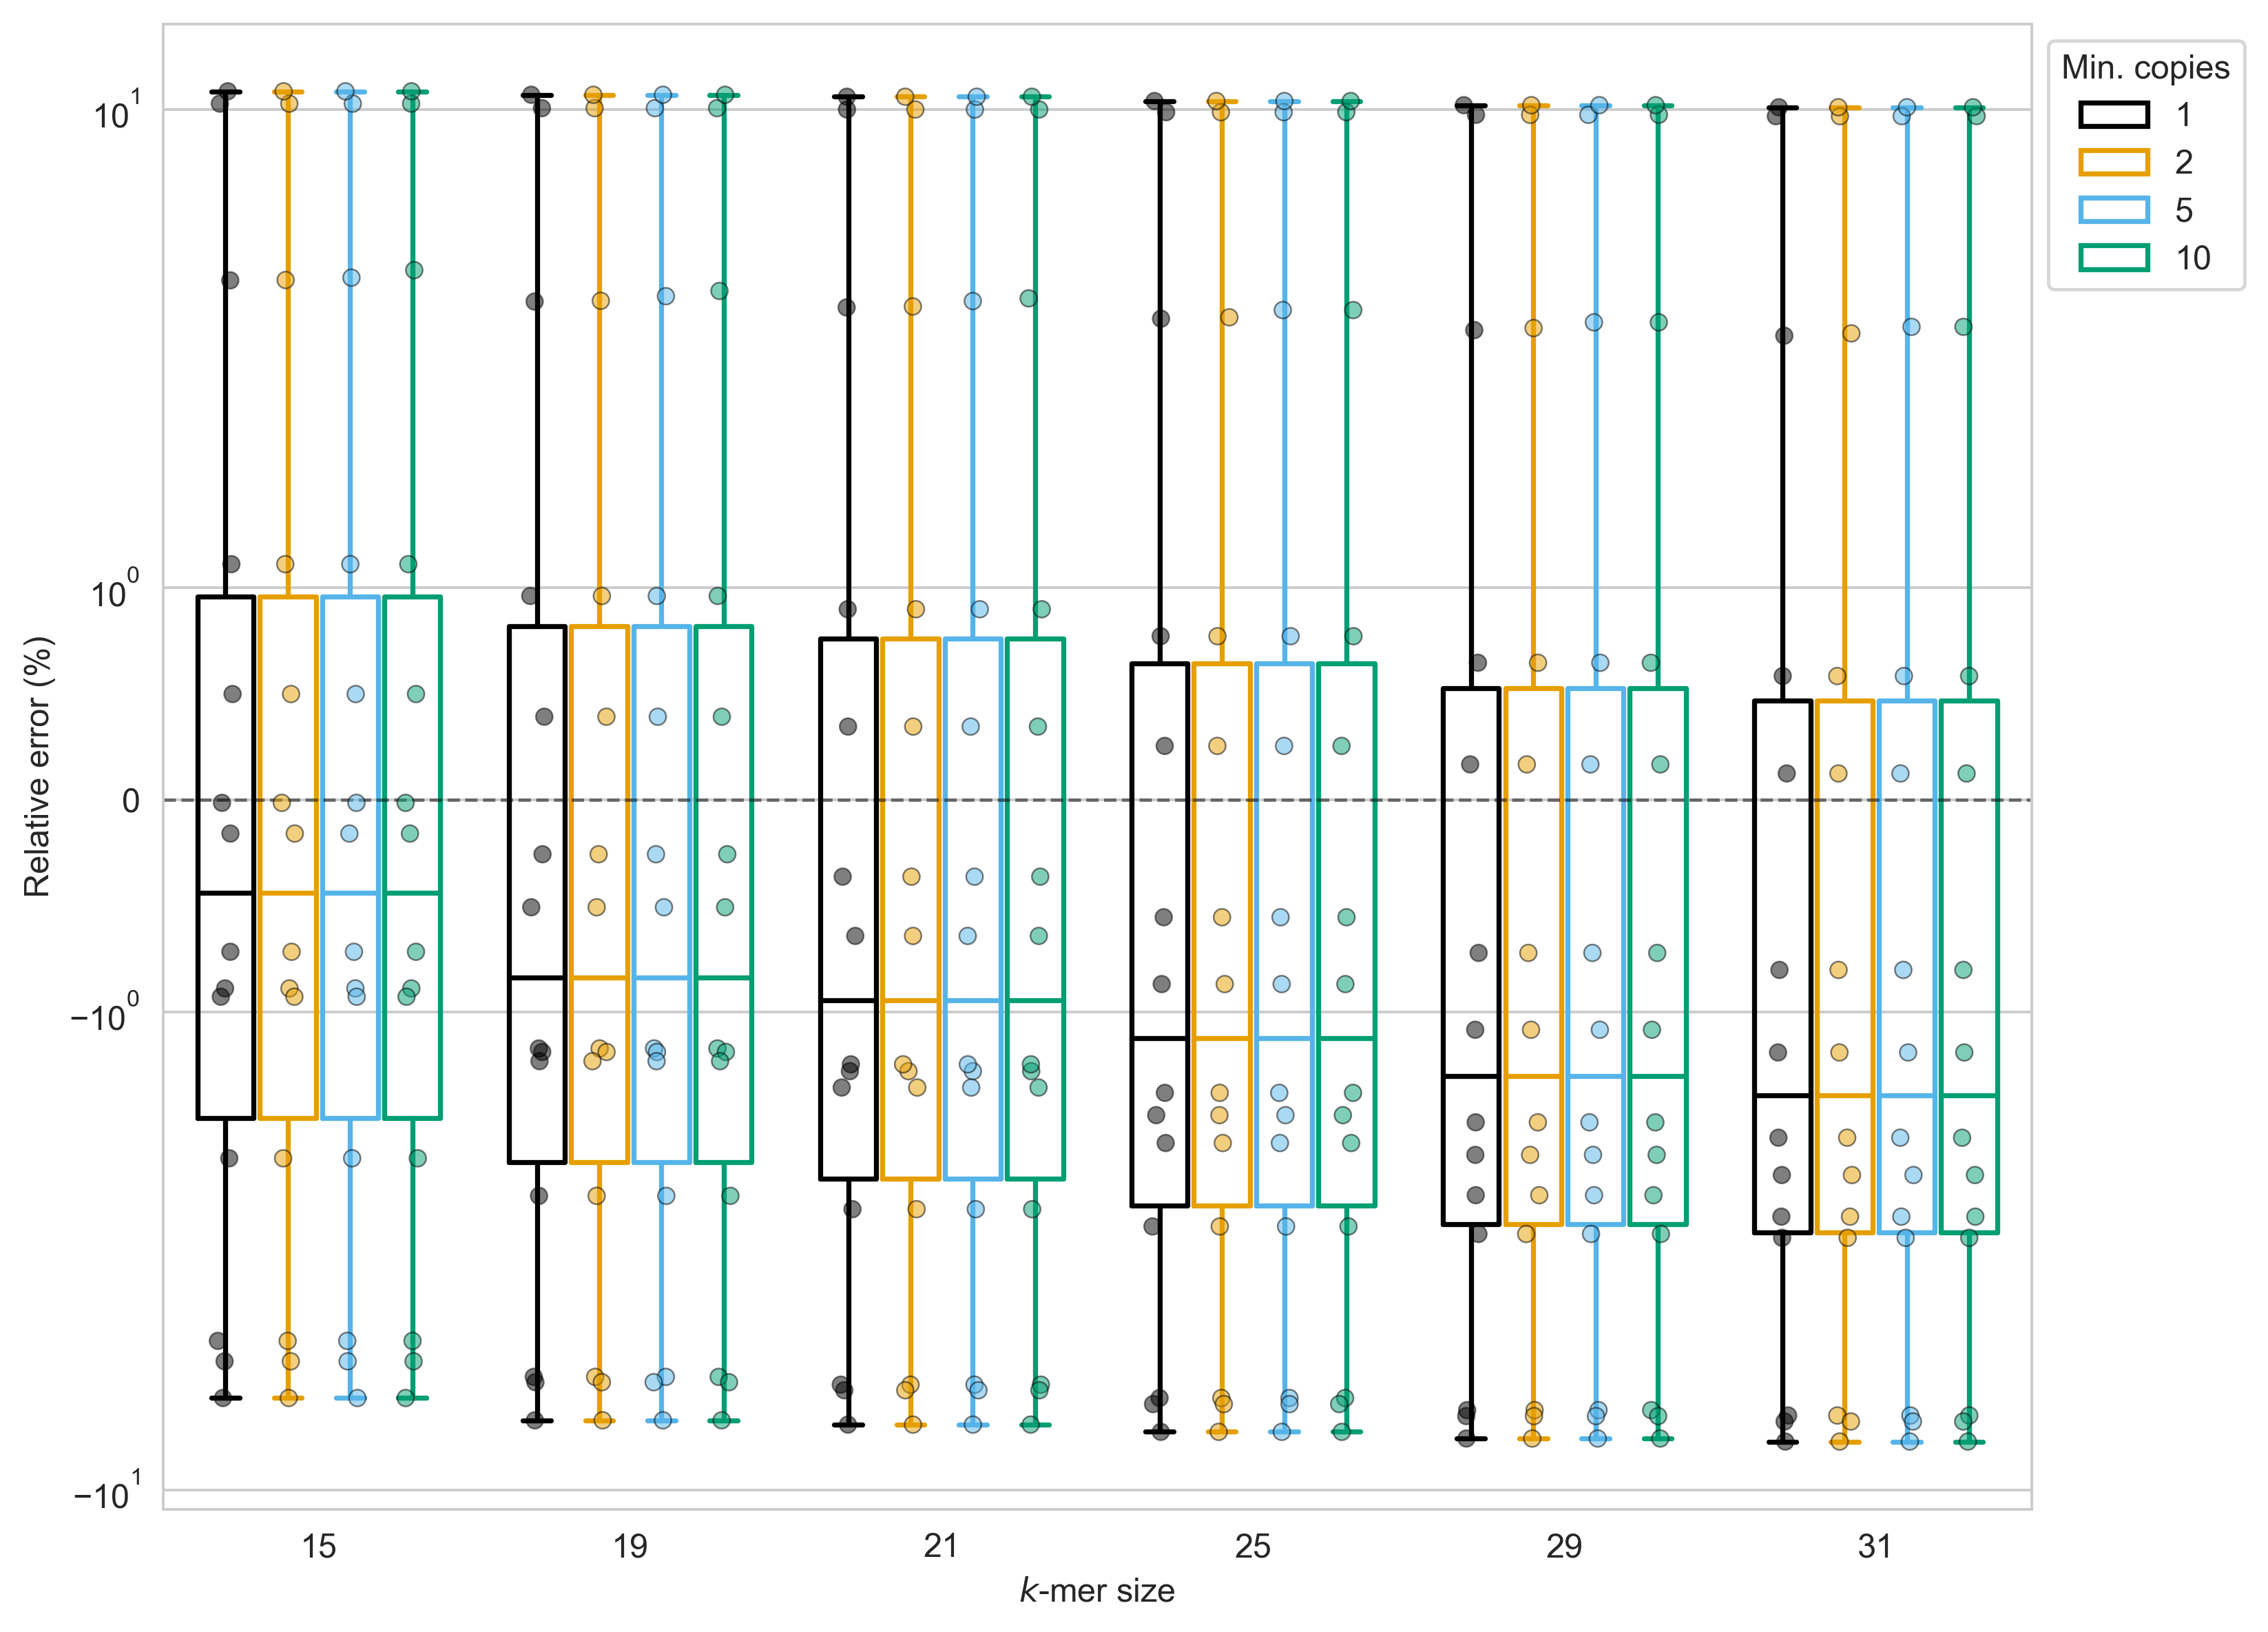

In [25]:
fig, ax = plt.subplots(dpi=DPI, figsize=(10, 8))

# use min copies that are a multiple of 2
data = gscope#.query("min_copies > 1")
x = "kmer_size"
y = "rel_err"
hue = "min_copies"

ax.set_yscale("symlog")

sns.boxplot(
    data=data,
    x=x,
    y=y,
    ax=ax,
    hue=hue,
    dodge=True,
    fill=False,
    fliersize=0,
    palette=cud_palette,
    gap=0.1
)
sns.stripplot(
    data=data,
    x=x,
    y=y,
    ax=ax,
    hue=hue,
    dodge=True,
    alpha=0.5,
    palette=cud_palette,
    legend=False,
    edgecolor="black",
    linewidth=0.5,
)

ax.set_ylabel("Relative error (%)")
ax.set_xlabel("$k$-mer size")

# set the legend title to Min. copies
handles, labels = ax.get_legend_handles_labels()
# move the legend outside the plot
ax.legend(handles, labels, title="Min. copies", loc="upper left", bbox_to_anchor=(1, 1))

# yticks = [-10, -1, 0, 1, 10, 50, 100, 500, 1000]
# ax.set_yticks(yticks)
# ax.set_yticklabels(yticks)

# make the y gridline at zero thicker
ax.axhline(0, color="black", lw=1, alpha=0.5, linestyle="--")

# ax.set_ylim(0.5, 2.0)

In [26]:
fig.savefig(FIGURES / "genomescope_param_explore.pdf", bbox_inches="tight")

In [12]:
best_mash_sketch_size = 100_000
best_mash_min_copies = 10

best_mash = mash.query("sketch_size == @best_mash_sketch_size and min_copies == @best_mash_min_copies")

best_gscope_kmer_size = 15
best_gscope_min_copies = 1

best_gscope = gscope.query("kmer_size == @best_gscope_kmer_size and min_copies == @best_gscope_min_copies")

In [13]:
# merge best mash and gscope, dropping columns that are not shared
best = pd.concat([best_mash, best_gscope], join="inner")

In [14]:
best_lrge_n_reads = 50000
best_lrge_strategy = "rand"
best_lrge = df.query("n_reads == @best_lrge_n_reads and strategy == @best_lrge_strategy")
# merge best with best_lrge
best = pd.concat([best, best_lrge])

In [15]:
def r2(df) -> float:
    """calculate the coefficient of determination for the estimates with respect to the 
    true size. If the df has replicates, the mean estimate for each sample is used.
    """
    subdf = df.groupby("sample").mean(numeric_only=True)
    est_mean = subdf["estimate"].mean()
    # total sum of squares
    ss_tot = ((subdf["estimate"] - est_mean) ** 2).sum()
    # residual sum of squares (difference from the identity line where y = x)
    ss_res = ((subdf["estimate"] - subdf["true_size"]) ** 2).sum()
    # calculate R^2
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [16]:
from typing import List

# colourblind-friendly palette from colour universal design (CUD)
# https://jfly.uni-koeln.de/color/
named_colors = {
    "black": "#000000",
    "orange": "#e69f00",
    "skyblue": "#56b4e9",
    "bluish green": "#009e73",
    "yellow": "#f0e442",
    "blue": "#0072b2",
    "vermilion": "#d55e00",
    "reddish purple": "#cc79a7",
}
cud_palette = list(named_colors.values())


def cud(n: int = len(cud_palette), start: int = 0) -> List[str]:
    remainder = cud_palette[:start]
    palette = cud_palette[start:] + remainder
    return palette[:n]

Text(0.5, 0, '')

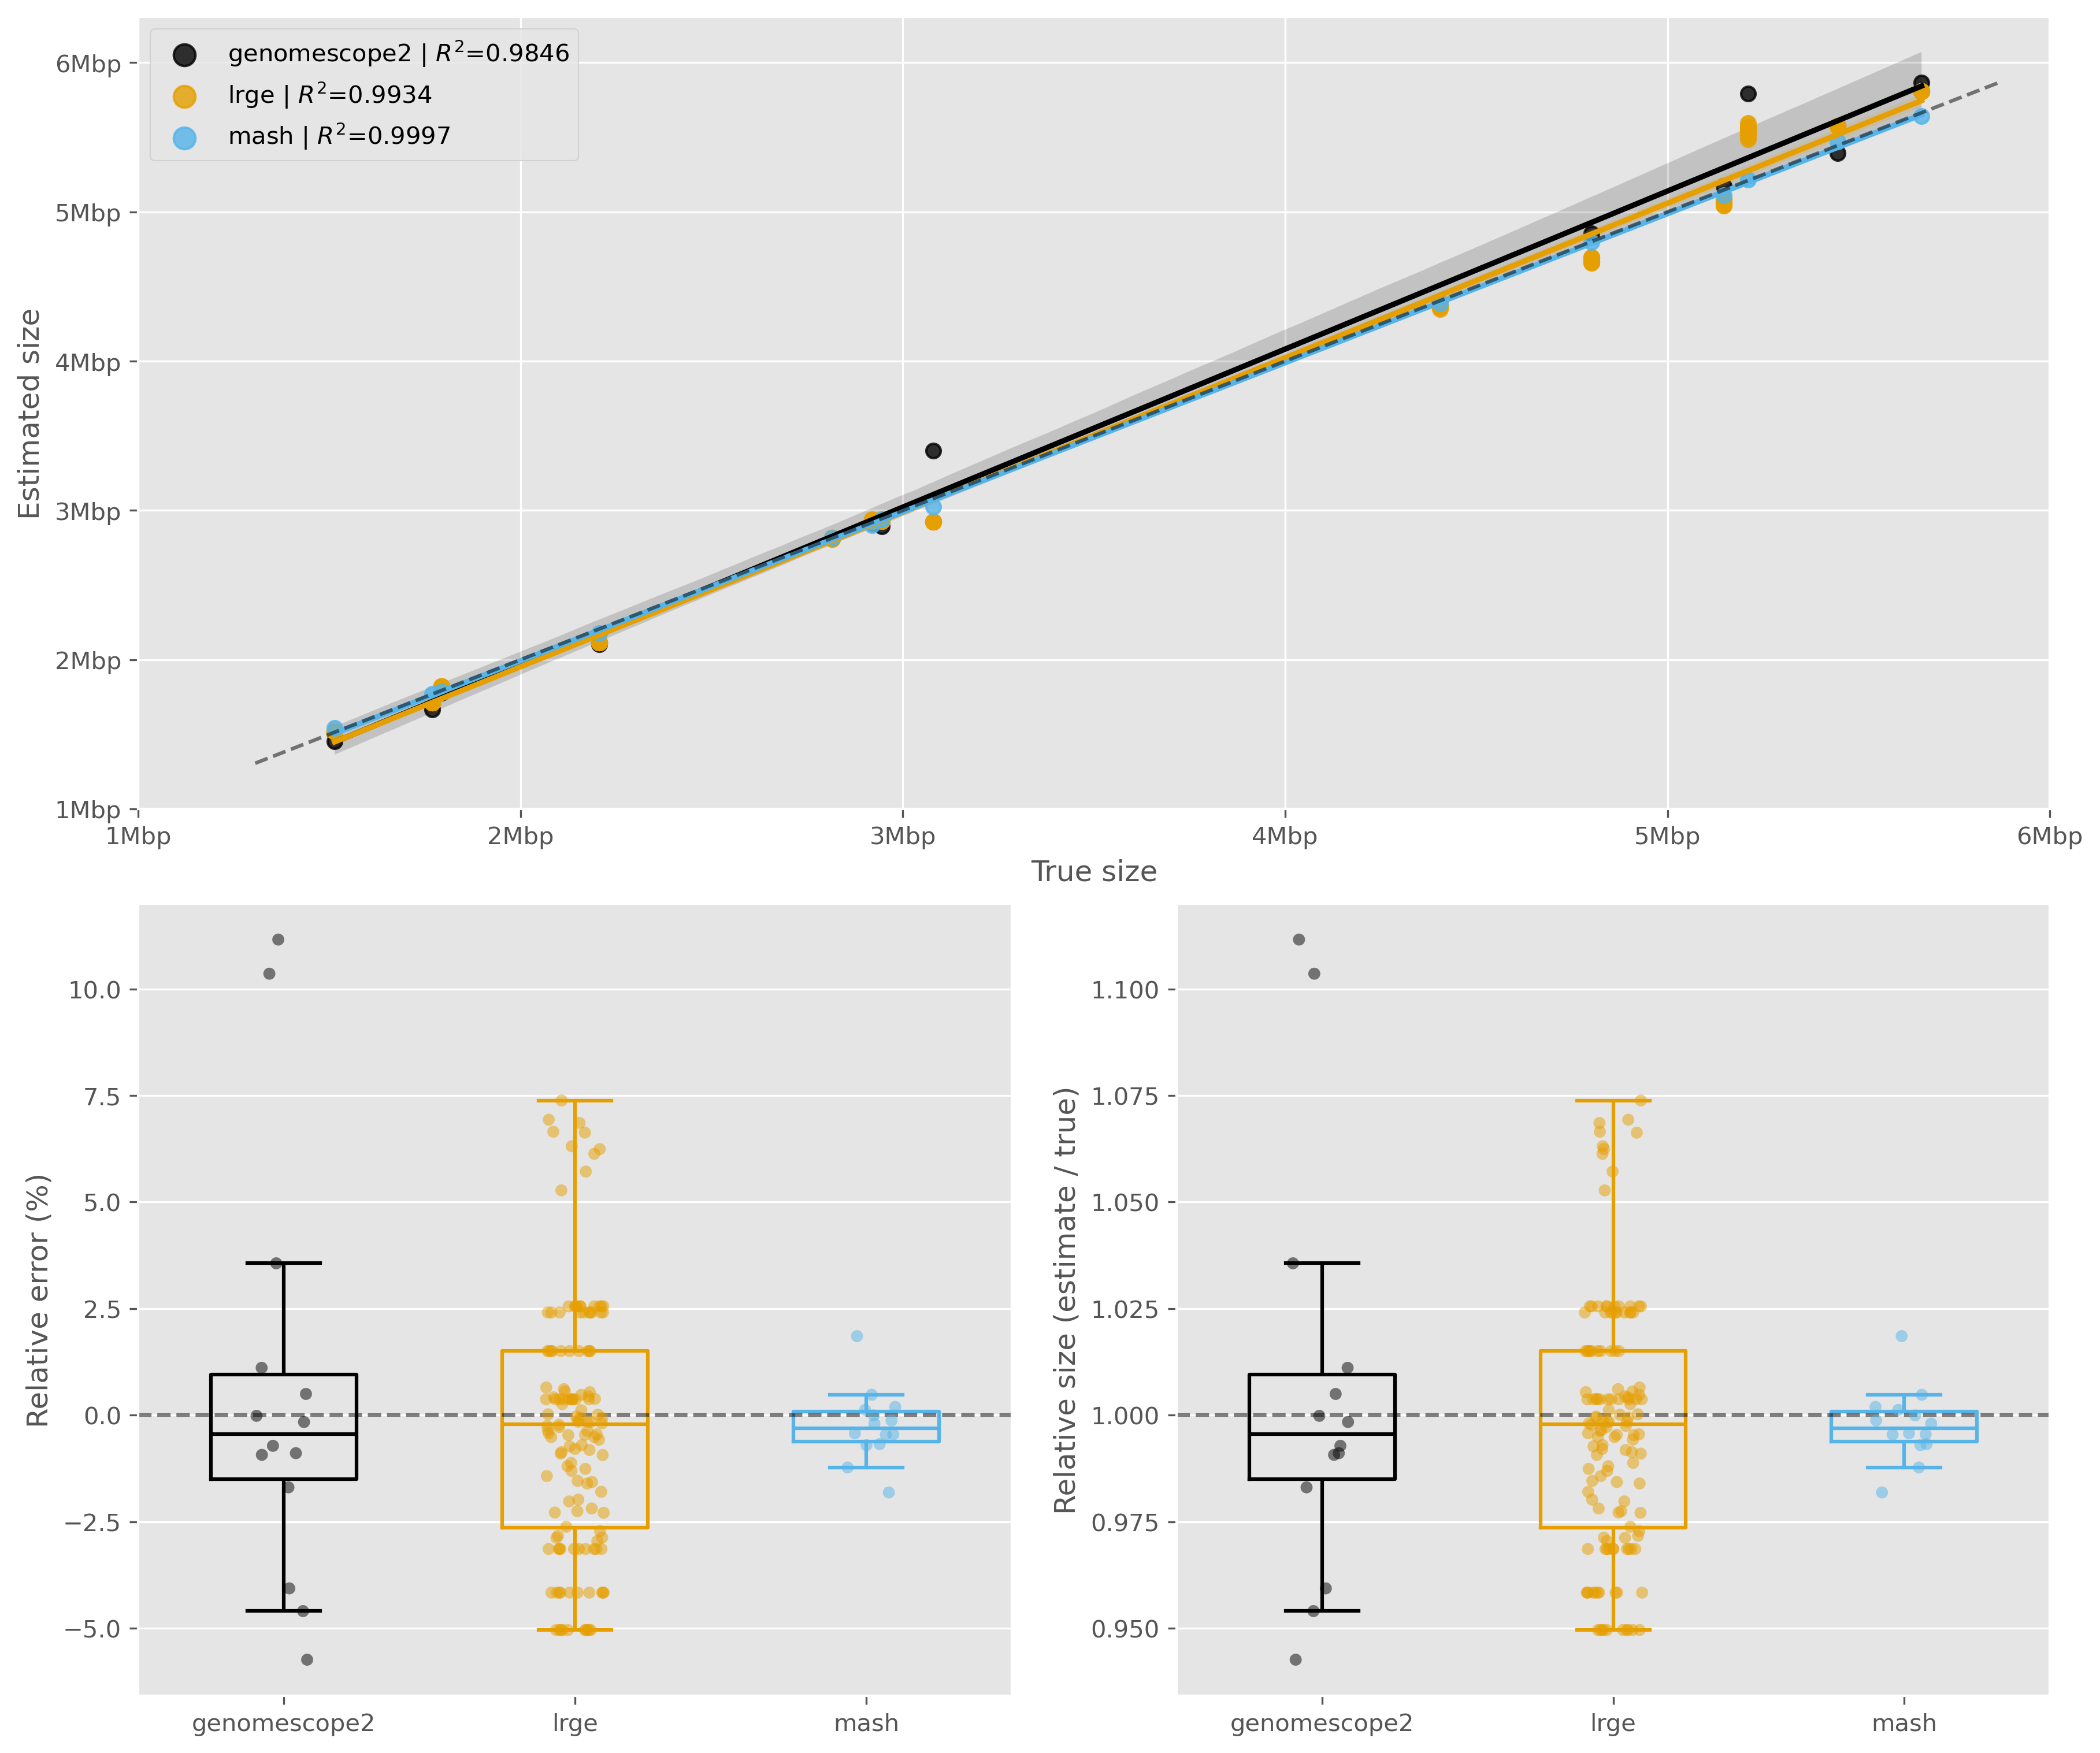

In [ ]:
from matplotlib.gridspec import GridSpec
# plt.style.use("seaborn-v0_8")
fig = plt.figure(figsize=(12, 10), dpi=DPI, layout="constrained")
# make two rows, the tope row with 1 column and the bottom row with 2 columns
gs = GridSpec(2, 2, figure=fig)
top_ax = fig.add_subplot(gs[0, :])
bleft_ax = fig.add_subplot(gs[1, 0])
bright_ax = fig.add_subplot(gs[1, 1])
methods = sorted(best["method"].unique())
palette = cud(len(methods))

# ============================
# plot the top plot
x = "true_size"
y = "estimate"
hue = "method"
r2_values = []
for i, method in enumerate(methods):
    subdf = best.query("method == @method")
    colour = palette[i]
    sns.regplot(data=subdf, x=x, y=y, ax=top_ax, label=method, color=colour)
    # calculate r^2 for the top plot and add text to the top plot
    r2_val = r2(subdf)
    r2_values.append((method, r2_val))

add_identity(top_ax, color="black", ls="--", alpha=0.5)
top_ax.set_xlabel("True size")
top_ax.set_ylabel("Estimated size")
# add the r2 values to the legend label for each method
top_ax.legend()
handles, labels = top_ax.get_legend_handles_labels()
top_ax.legend(handles, [f"{label} | $R^2$={r2:.4f}" for label, r2 in r2_values], markerscale=1.5, fontsize=10, loc="upper left")
ticks = [i * 1e6 for i in range(1, 7)]
top_ax.set_xticks(ticks)
top_ax.set_xticklabels([f"{i}Mbp" for i in range(1, 7)])
top_ax.set_yticks(ticks)
top_ax.set_yticklabels([f"{i}Mbp" for i in range(1, 7)])
# ============================
# plot the bottom left plot
x = "method"
y = "rel_err"
hue = "method"
shared_kwargs = dict(
    x=x, hue=hue, y=y, hue_order=methods, order=methods, ax=bleft_ax, data=best, palette=palette
)
box_kwargs = dict(**shared_kwargs, fill=False, width=0.5, fliersize=0)
sns.boxplot(**box_kwargs)
strip_kwargs = dict(**shared_kwargs, dodge=False, alpha=0.5)
sns.stripplot(**strip_kwargs)
bleft_ax.axhline(0, color="black", ls="--", alpha=0.5)
bleft_ax.set_ylabel("Relative error (%)")
bleft_ax.set_xlabel("")
# ============================
# plot the bottom right plot
y = "rel_size"
shared_kwargs.update(dict(y=y, ax=bright_ax))
box_kwargs.update(**shared_kwargs)
sns.boxplot(**box_kwargs)
strip_kwargs.update(**shared_kwargs)
sns.stripplot(**strip_kwargs)
bright_ax.axhline(1, color="black", ls="--", alpha=0.5)
bright_ax.set_ylabel("Relative size (estimate / true)")
bright_ax.set_xlabel("")

In [96]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [59]:
from collections import defaultdict, Counter

In [68]:
n_olaps = Counter()
sample = "AMtb_1"
ps = list(Path(f"/data/scratch/projects/punim2009/genome_size/param_explore_ava/rand/n50000/{sample}/.lrge").glob("*.paf"))
with open(ps[0]) as f:
    for line in f:
        n_olaps[line.split("\t")[5]] += 1

<Axes: ylabel='Count'>

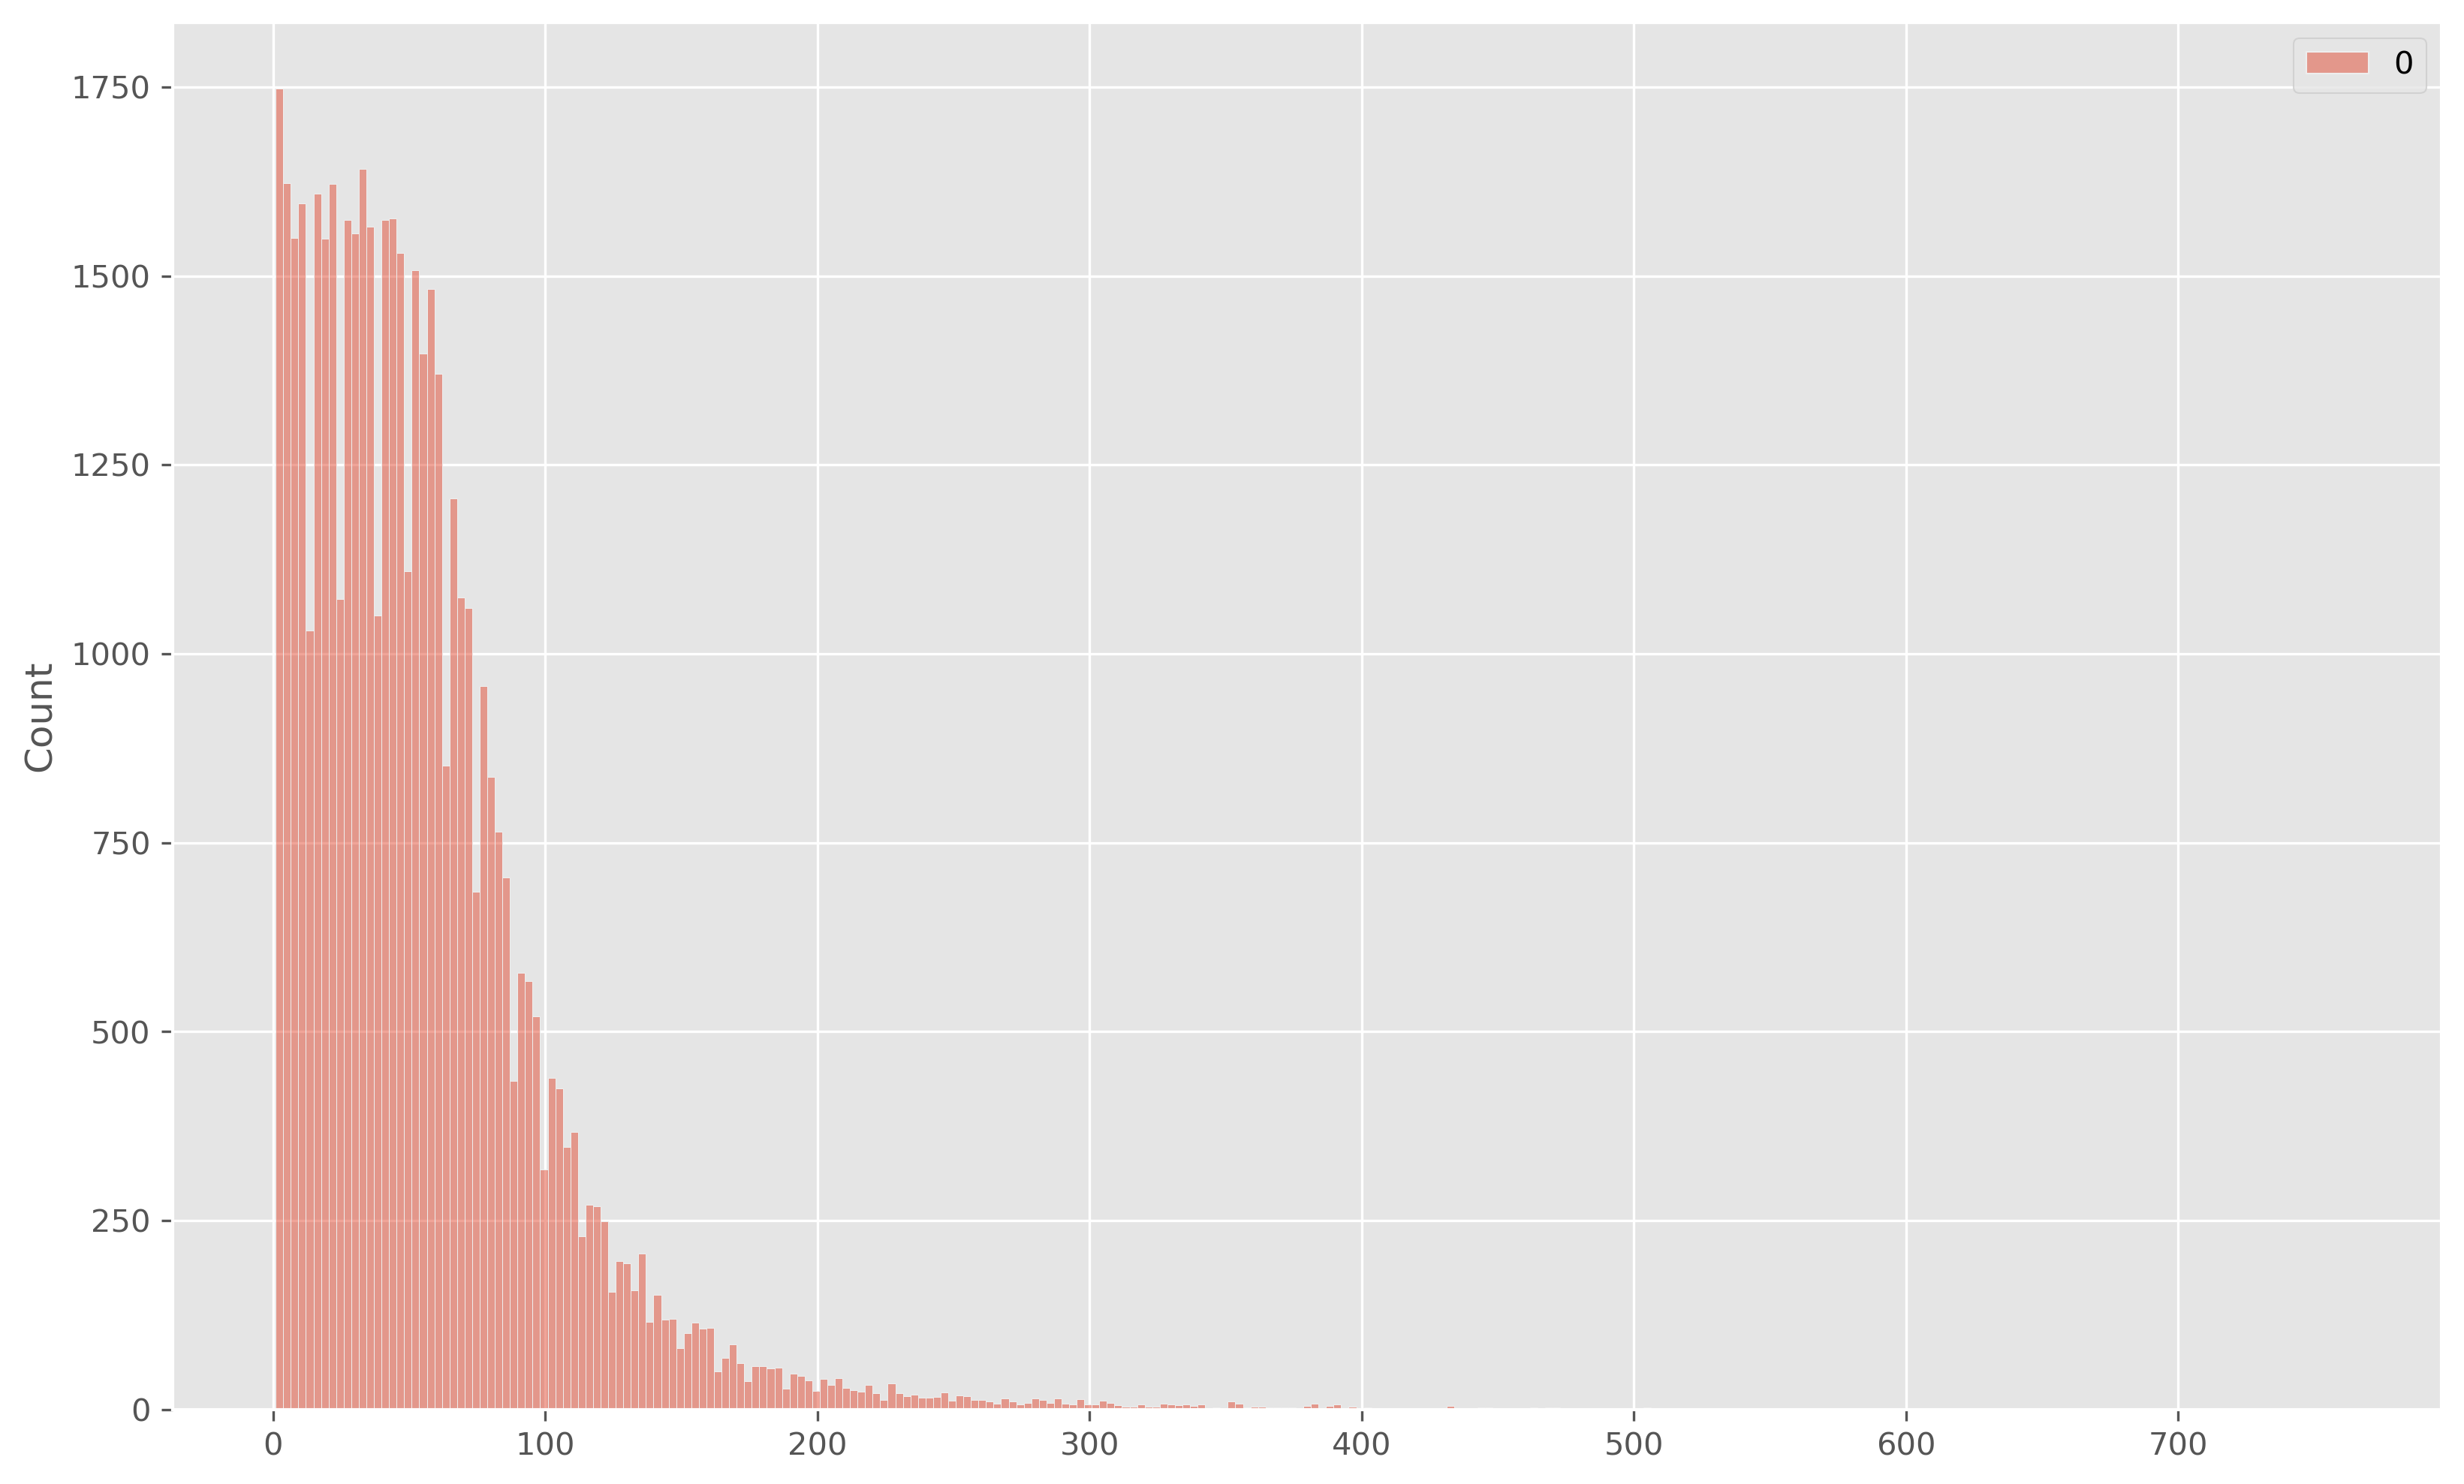

In [69]:
sns.histplot(n_olaps.values())

In [71]:
pd.Series(n_olaps).describe()

count    49046.000000
mean        56.459018
std         50.317712
min          1.000000
25%         23.000000
50%         47.000000
75%         74.000000
max        759.000000
dtype: float64

In [67]:
n_olaps.most_common(10)

[('f0f033f2-3df4-4ce7-b593-dd7ce62e07e6', 2368),
 ('e0504670-dd36-4a46-b70e-7bb1e559fd6b', 2253),
 ('f2c98f11-529b-40e4-9af8-afd948b8c787', 2189),
 ('f2b663d5-d01b-432d-b9b1-56182f64e0a3', 2068),
 ('c4645fb1-a1f4-4037-aaa6-17ef729666bf', 2005),
 ('b59fa235-5535-4f0c-888b-d6b8fd58289c', 1986),
 ('f6a7f10d-c70e-44d6-9dbb-e3aac32afa6c', 1802),
 ('e83db89d-6221-47a1-af64-770fb9259fa4', 1770),
 ('e7e8febb-cd40-42fa-8dbf-d5fe2db2fcc8', 1703),
 ('dbe52fa4-2ae5-425f-ac14-005264a02e13', 1690)]

In [86]:
# as a santiy check, see what the total number of overlaps is for each read depending on 
# whether we use the qname or tname column in the PAF file
n_olaps_qname = Counter()
n_olaps_tname = Counter()
for p in ps:
    with open(p) as f:
        for line in f:
            n_olaps_qname[line.split("\t")[0]] += 1
            n_olaps_tname[line.split("\t")[5]] += 1

In [103]:
diffs = []
for k in n_olaps_qname:
    diffs.append(abs(n_olaps_qname[k] - n_olaps_tname[k]))

In [104]:
len(n_olaps_qname), len(n_olaps_tname)

(49067, 49046)

In [105]:
pd.Series(diffs).describe()

count    49067.000000
mean        55.875313
std         50.419788
min          0.000000
25%         23.000000
50%         46.000000
75%         73.000000
max        677.000000
dtype: float64

<Axes: ylabel='Count'>

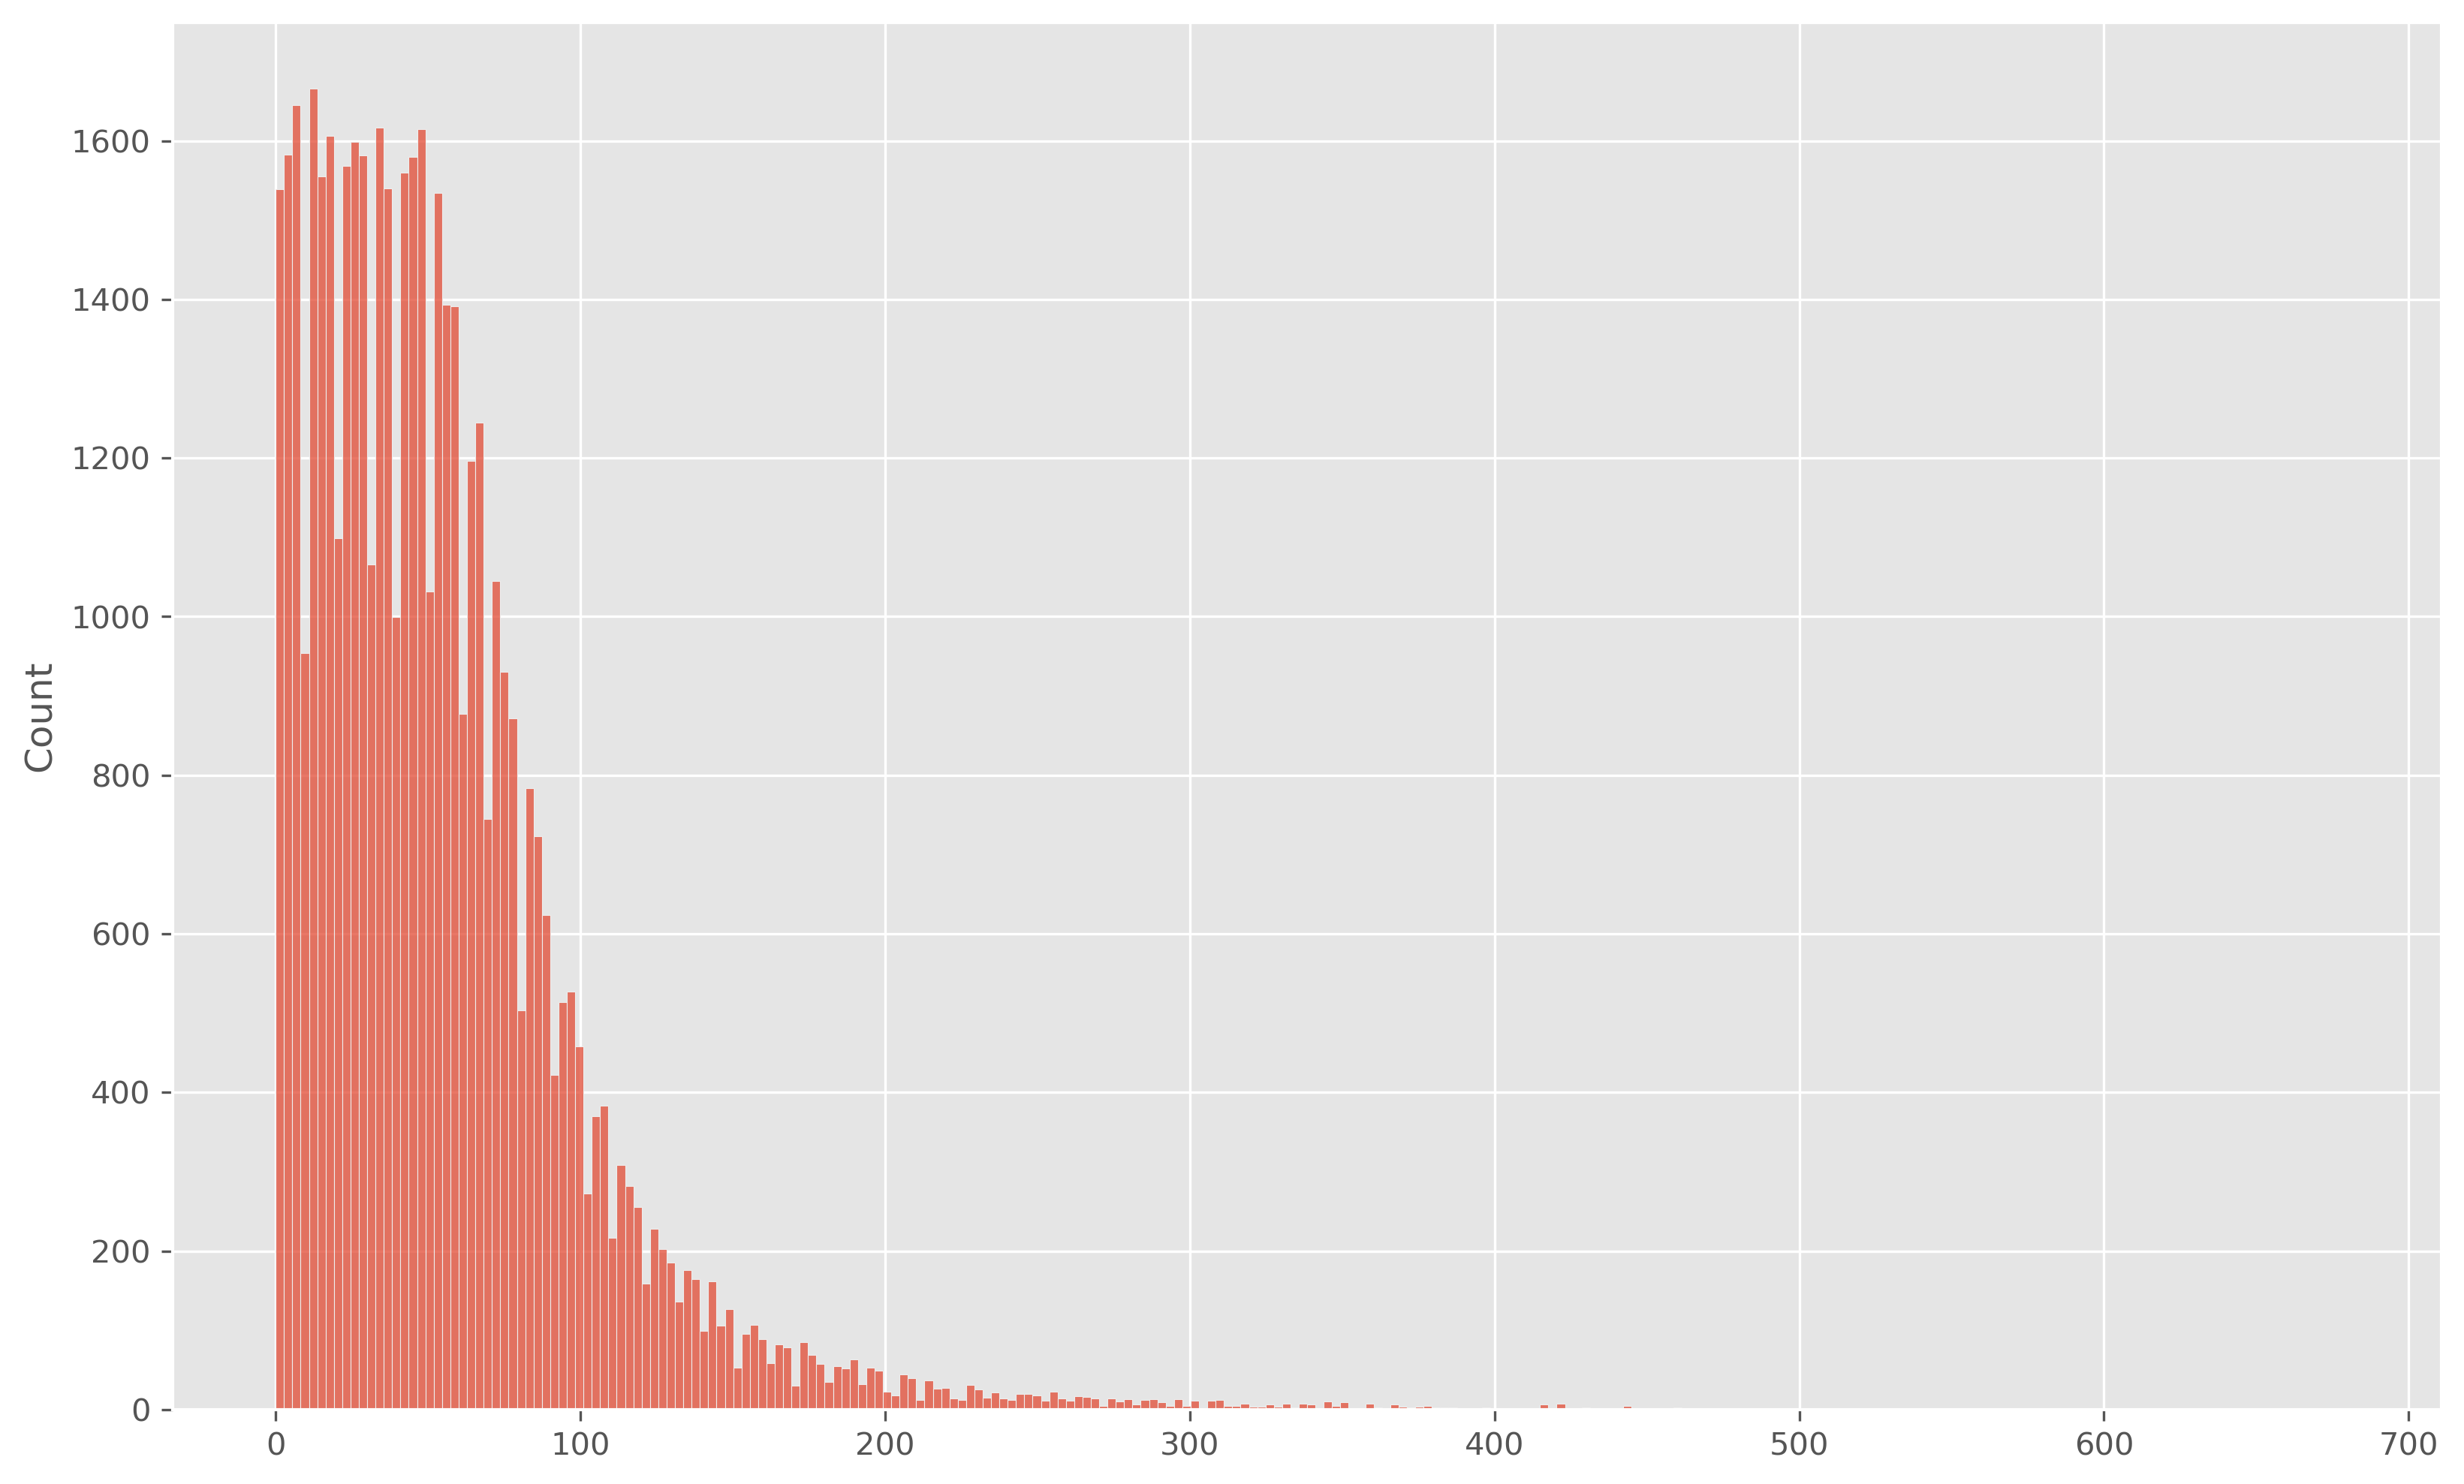

In [106]:
sns.histplot(diffs)